In [1]:
import pandas as pd
import numpy as np
import os
import math
import random
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import scipy
from scipy import optimize
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns
from multiprocessing import Pool
from matplotlib.colors import LinearSegmentedColormap
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import scanpy as sc


In [2]:
import numpy as np

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [6]:
'read h5ad'
gbm_for_LR = sc.read_h5ad('/home/qukun/ccp1997/GBM_10X/ng_revised/public_data/GBmap/GBmap_for_LR_top100.h5ad')

'generate norm and meta data'
norm = pd.DataFrame(gbm_for_LR.X.todense(),index=gbm_for_LR.obs.index,columns=gbm_for_LR.var.index)
meta_data = gbm_for_LR.obs

'Load interaction'
ER1_four_quadrant = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/ER1_four_quadrant.csv',index_col=0)
ER2_four_quadrant = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/ER2_four_quadrant.csv',index_col=0)
ER3_four_quadrant = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/ER3_four_quadrant.csv',index_col=0)
ER4_four_quadrant = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/ER4_four_quadrant.csv',index_col=0)

'Interaction strength'
Interaction_strength = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/commot/Interaction_strength_table.csv',index_col=0)

'Load spatial domain info'
Spatial_domain = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/visium_matrix/spatial_domain_table_ER.csv',index_col=0)
Spatial_domain = Spatial_domain.loc[Interaction_strength.index]

In [7]:
'ER1 select triangle'

ER1_ligand = list(set([ item.split('_')[0] for item in ER1_four_quadrant.loc[ER1_four_quadrant['pathway'].isin(['VEGF','IL6','MIF'])].index]))
exp_dataframe = pd.DataFrame(index= ER1_ligand
                             ,columns=['MES1','MES2','AC-like','NPC-like','OPC-like','neurons','Oligodendrocyte','Endo','Pericyte','VSMCs','TAM1','TAM2','TAM3','TAM4','TAM5','Monocytes','DC cells',
                   'NK cells','T-IFI6','Cytotoxic CD8T','Exhausted CD8T','T-HSPA1A','CD4T','Treg cells','B cells','Plasma cells'] )


In [9]:
'cluster proportion ratio analysis'

spatial_domain_table = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/visium_matrix/spatial_domain_table_ER.csv',index_col=0)
c2location_table = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/visium_matrix/all_spots_c2location.csv',index_col=0)

spatial_domain_table = spatial_domain_table.loc[spatial_domain_table['STME'] != 'NM']
c2location_table = c2location_table.loc[spatial_domain_table.index]

c2location_table.columns = c2location_table.columns[:7].tolist() + ['MES1'] + c2location_table.columns[8:].tolist()
c2location_table['MES2'] = c2location_table['MES1']

c2location_table = c2location_table[exp_dataframe.columns]

STME1_ratio = c2location_table.loc[spatial_domain_table.loc[spatial_domain_table['STME'] == 'STME-1'].index].mean()
STME2_ratio = c2location_table.loc[spatial_domain_table.loc[spatial_domain_table['STME'] == 'STME-2'].index].mean()
STME3_ratio = c2location_table.loc[spatial_domain_table.loc[spatial_domain_table['STME'] == 'STME-3'].index].mean()
STME4_ratio = c2location_table.loc[spatial_domain_table.loc[spatial_domain_table['STME'] == 'STME-4'].index].mean()

c2l_average_table = pd.concat([STME1_ratio,STME2_ratio,STME3_ratio,STME4_ratio],axis=1)
c2l_average_table.columns =['STME1','STME2','STME3','STME4']

In [10]:
MES_mapping = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/MES_recluster/MES_mapping_STME_result.csv',index_col=0)

'MES1 ratio'
MES1_STME1_ratio = MES_mapping.loc[MES_mapping['annotation'] == 'MES1'].value_counts('max_item').loc['STME-1'] / MES_mapping.loc[MES_mapping['annotation'] == 'MES1'].value_counts('max_item').loc['STME-2']   
MES1_STME2_ratio = MES_mapping.loc[MES_mapping['annotation'] == 'MES1'].value_counts('max_item').loc['STME-2'] / MES_mapping.loc[MES_mapping['annotation'] == 'MES1'].value_counts('max_item').loc['STME-2'] 
MES1_STME3_ratio = MES_mapping.loc[MES_mapping['annotation'] == 'MES1'].value_counts('max_item').loc['STME-3'] / MES_mapping.loc[MES_mapping['annotation'] == 'MES1'].value_counts('max_item').loc['STME-2'] 
MES1_STME4_ratio = MES_mapping.loc[MES_mapping['annotation'] == 'MES1'].value_counts('max_item').loc['STME-4'] / MES_mapping.loc[MES_mapping['annotation'] == 'MES1'].value_counts('max_item').loc['STME-2'] 
MES1_ratio_list = [MES1_STME1_ratio,MES1_STME2_ratio,MES1_STME3_ratio,MES1_STME4_ratio]

'MES2 ratio'
MES2_STME1_ratio = MES_mapping.loc[MES_mapping['annotation'] == 'MES2'].value_counts('max_item').loc['STME-1'] / MES_mapping.loc[MES_mapping['annotation'] == 'MES2'].value_counts('max_item').loc['STME-1']   
MES2_STME2_ratio = MES_mapping.loc[MES_mapping['annotation'] == 'MES2'].value_counts('max_item').loc['STME-2'] / MES_mapping.loc[MES_mapping['annotation'] == 'MES2'].value_counts('max_item').loc['STME-1'] 
MES2_STME3_ratio = MES_mapping.loc[MES_mapping['annotation'] == 'MES2'].value_counts('max_item').loc['STME-3'] / MES_mapping.loc[MES_mapping['annotation'] == 'MES2'].value_counts('max_item').loc['STME-1'] 
MES2_STME4_ratio = MES_mapping.loc[MES_mapping['annotation'] == 'MES2'].value_counts('max_item').loc['STME-4'] / MES_mapping.loc[MES_mapping['annotation'] == 'MES2'].value_counts('max_item').loc['STME-1'] 
MES2_ratio_list = [MES2_STME1_ratio,MES2_STME2_ratio,MES2_STME3_ratio,MES2_STME4_ratio]


In [14]:
'ER-1 ligand expression'
def upper_genes(cluster):
    ratio = 0.20
    cells = meta_data.loc[meta_data['annotation'] == cluster].index.tolist()
    cutoff=  int(len(cells)*ratio)
    record = []
    select_norm = norm.loc[cells]
        
    for gene in exp_dataframe.index:
        record.append( np.mean(select_norm.sort_values(gene,ascending=False)[gene][:cutoff] ) )
    return record

pool = Pool(25)
k = pool.map(upper_genes, exp_dataframe.columns.tolist() )
pool.close()
pool.join()

exp_dataframe = pd.DataFrame(k,columns=exp_dataframe.index ,index= exp_dataframe.columns).T
exp_dataframe_refine = pd.DataFrame(index=exp_dataframe.index, columns=exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in exp_dataframe_refine.index:
    record = []
    for cluster in exp_dataframe_refine.columns:
        if cluster in ['MES1']:
            if MES1_STME1_ratio <= ratio_cutoff:
                record.append( exp_dataframe.loc[gene][cluster] * MES1_STME1_ratio )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME1_ratio <= ratio_cutoff:
                record.append( exp_dataframe.loc[gene][cluster] * MES2_STME1_ratio )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME1_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( exp_dataframe.loc[gene][cluster] * (STME1_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
    
    exp_dataframe_refine.loc[gene] = record

exp_dataframe_zscore = pd.DataFrame(index = exp_dataframe_refine.index,columns= exp_dataframe_refine.columns)
for gene in exp_dataframe_refine.index:
    exp_dataframe_zscore.loc[gene] = stats.zscore(exp_dataframe_refine.loc[gene].tolist())
    
exp_dataframe_zscore[list(exp_dataframe_zscore.columns)]=exp_dataframe_zscore[list(exp_dataframe_zscore.columns)].astype(float)

<AxesSubplot:>

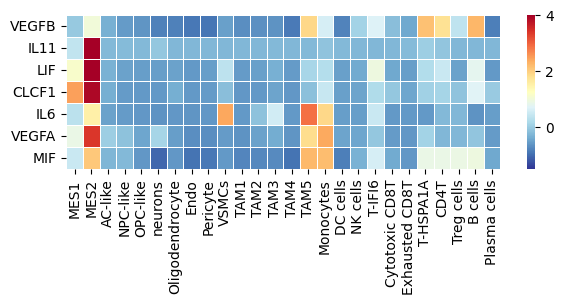

In [15]:
plt.figure(figsize=(7,2))
sns.heatmap(exp_dataframe_zscore,vmax=4,vmin=-1.5,cmap='RdYlBu_r',linewidths=0.50)

In [ ]:
'ER1 receptor expression'
ER1_receptor = list(set([ item.split('_')[1] for item in ER1_four_quadrant.loc[ER1_four_quadrant['pathway'].isin(['VEGF','IL6','MIF'])].index]))

receptor_exp_dataframe = pd.DataFrame(index= ER1_receptor
                                      
                                      ,columns=['MES1','MES2','AC-like','NPC-like','OPC-like','neurons','Oligodendrocyte','Endo','Pericyte','VSMCs','TAM1','TAM2','TAM3','TAM4','TAM5','Monocytes','DC cells',
                   'NK cells','T-IFI6','Cytotoxic CD8T','Exhausted CD8T','T-HSPA1A','CD4T','Treg cells','B cells','Plasma cells'] )

def upper_genes(cluster):
    ratio = 0.20
    cells = meta_data.loc[meta_data['annotation'] == cluster].index.tolist()
    cutoff=  int(len(cells)*ratio)
    record = []
    select_norm = norm.loc[cells]
        
    for gene in receptor_exp_dataframe.index:
        record.append( np.mean(select_norm.sort_values(gene,ascending=False)[gene][:cutoff] ) )
        
    return record

pool = Pool(25)
k = pool.map(upper_genes, receptor_exp_dataframe.columns.tolist() )
pool.close()
pool.join()

receptor_exp_dataframe = pd.DataFrame(k,columns=receptor_exp_dataframe.index ,index= receptor_exp_dataframe.columns).T

receptor_exp_dataframe_refine = pd.DataFrame(index=receptor_exp_dataframe.index, columns=receptor_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in receptor_exp_dataframe_refine.index:
    record = []
    for cluster in receptor_exp_dataframe_refine.columns:
        if cluster in ['MES1']:
            if MES1_STME1_ratio <= ratio_cutoff:
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( receptor_exp_dataframe.loc[gene][cluster] * MES1_STME1_ratio )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME1_ratio <= ratio_cutoff:
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( receptor_exp_dataframe.loc[gene][cluster] * MES2_STME1_ratio )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME1_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * (STME1_ratio/c2l_average_table.max(axis=1))[cluster] )
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )

    receptor_exp_dataframe_refine.loc[gene] = record

receptor_exp_dataframe_refine_zscore = pd.DataFrame(index = receptor_exp_dataframe_refine.index,columns= receptor_exp_dataframe_refine.columns)
for gene in receptor_exp_dataframe_refine.index:
    receptor_exp_dataframe_refine_zscore.loc[gene] = stats.zscore(receptor_exp_dataframe_refine.loc[gene].tolist())
    
receptor_exp_dataframe_refine_zscore[list(receptor_exp_dataframe_refine_zscore.columns)]=receptor_exp_dataframe_refine_zscore[list(receptor_exp_dataframe_refine_zscore.columns)].astype(float)
receptor_exp_dataframe_refine[list(receptor_exp_dataframe_refine.columns)]=receptor_exp_dataframe_refine[list(receptor_exp_dataframe_refine.columns)].astype(float)

<AxesSubplot:>

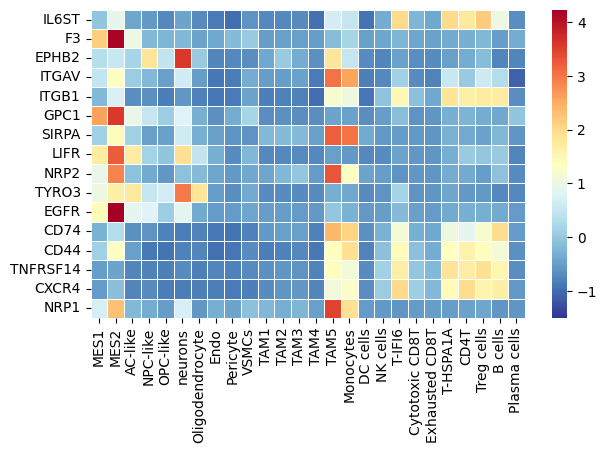

In [ ]:
plt.figure(figsize=(7,4))
sns.heatmap(receptor_exp_dataframe_refine_zscore,cmap='RdYlBu_r',linewidths=0.50,vmin=-1.5)

In [23]:
'norm to 0-1'
exp_dataframe_refine_scale = pd.DataFrame(index=exp_dataframe_refine.index,columns=exp_dataframe_refine.columns)
for ligand in exp_dataframe_refine_scale.index:
    exp_dataframe_refine_scale.loc[ligand] = NormalizeData(exp_dataframe_refine.loc[ligand])

receptor_exp_dataframe_refine_scale = pd.DataFrame(index= receptor_exp_dataframe_refine.index, columns= receptor_exp_dataframe_refine.columns)
for receptor in receptor_exp_dataframe_refine_scale.index:
    receptor_exp_dataframe_refine_scale.loc[receptor] = NormalizeData(receptor_exp_dataframe_refine.loc[receptor])

In [27]:
'downsampling'

ER1_LR_pairs_list = ['VEGFA_NRP1','VEGFA_NRP2'] + ['LIF_LIFR','IL11_IL6ST'] + ['MIF_CD44','MIF_CD74']

ER1_Triangle_list = []
ER1_Triangle_list_raw = []
for LR_pairs in ER1_LR_pairs_list:
    Triangle = pd.DataFrame(index= exp_dataframe_zscore.columns, columns= exp_dataframe_zscore.columns)

    for cluster in Triangle.index:
        for item in Triangle.columns:
            Triangle.loc[cluster][item] = exp_dataframe_refine.loc[LR_pairs.split('_')[0]].loc[cluster] * receptor_exp_dataframe_refine.loc[LR_pairs.split('_')[1]].loc[item]
    Triangle[list(Triangle.columns)]=Triangle[list(Triangle.columns)].astype(float)

    'downsampling'
    Top3_ligand_clust = exp_dataframe_refine.loc[LR_pairs.split('_')[0]].sort_values(ascending=False).index[:3]
    Top3_receptor_clust = receptor_exp_dataframe_refine.loc[LR_pairs.split('_')[1]].sort_values(ascending=False).index[:3]
    
    filter_Triangle = Triangle.loc[Top3_ligand_clust][Top3_receptor_clust]
    
    filter_Triangle[list(filter_Triangle.columns)]=filter_Triangle[list(filter_Triangle.columns)].astype(float)
    
    filter_Triangle.index = [ item + ',' + LR_pairs for item in filter_Triangle.index]
    filter_Triangle.columns = [ item + ',' + LR_pairs for item in filter_Triangle.columns]
    
    'downsampling'
    cut_limit = 0.50
    
    'row'
    row_filter = filter_Triangle.index[np.sum(filter_Triangle,axis=1) >= np.max(np.sum(filter_Triangle,axis=1)) * 0.50].tolist()
    'col'
    col_filter = filter_Triangle.columns[np.sum(filter_Triangle,axis=0) >= np.max(np.sum(filter_Triangle,axis=0)) * 0.50].tolist()
    
    if len(col_filter) == 1:
        row_filter = filter_Triangle.index[np.sum(filter_Triangle,axis=1) >= np.max(np.sum(filter_Triangle,axis=1)) * 1.0].tolist()

    filter_Triangle = filter_Triangle.loc[row_filter]
    filter_Triangle = filter_Triangle[col_filter]
   
    'random'
    random_index = filter_Triangle.index.tolist()
    random_columns = filter_Triangle.columns.tolist()
    random.shuffle(random_index)
    random.shuffle(random_columns)
    filter_Triangle = filter_Triangle.loc[random_index][random_columns]
    
    Triangle.index = [ item + ',' + LR_pairs for item in Triangle.index]
    Triangle.columns = [ item + ',' + LR_pairs for item in Triangle.columns]
    
    ER1_Triangle_list_raw.append(Triangle)
    ER1_Triangle_list.append(filter_Triangle)
    

In [28]:
index_list = []
column_list = []
for item in ER1_Triangle_list:
    index_list = index_list + item.index.tolist()
    column_list = column_list + item.columns.tolist()

ER1_merge_triangle = pd.DataFrame(index= index_list, columns=column_list)

for item in ER1_merge_triangle.index:
    for k in ER1_merge_triangle.columns:
        LR = item.split(',')[1].split('_')[0] +'_' + k.split(',')[1].split('_')[1]
        ligand = LR.split('_')[0]
        receptor = LR.split('_')[1]
        if LR not in Interaction_strength.columns.tolist():
            ER1_merge_triangle.loc[item][k] = 0
        else:
            ratio = np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] == 'STME-1'].index ]) / np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] != 'STME-1'].index ]) 
            ER1_merge_triangle.loc[item][k] = exp_dataframe_refine_scale.loc[ligand][item.split(',')[0]] * receptor_exp_dataframe_refine_scale.loc[receptor][k.split(',')[0]] * ratio
    
ER1_merge_triangle[list(ER1_merge_triangle.columns)]=ER1_merge_triangle[list(ER1_merge_triangle.columns)].astype(float)

exp_dataframe_refine_scale_STME_1 = exp_dataframe_refine_scale
receptor_exp_dataframe_refine_scale_STME_1 = receptor_exp_dataframe_refine_scale

In [32]:
row_gap_list = [ item.shape[0] for item in ER1_Triangle_list]
col_gap_list = [ item.shape[1] for item in ER1_Triangle_list]

In [33]:
clust_colors = {'TAM1':'#17728C','TAM2':'#C1EDF6','TAM3':'#C5E5BD','TAM4':'#89CFC5','TAM5':'#AA5FAC','Monocytes':'#748EBF','DC cells':'#00C8FB',\
                'Oligodendrocyte':'#AE958C',\
                'B cells':'#ECD157', 'Plasma cells':'#DABB57',\
                'Treg cells':'#fc912a','T-IFI6':'#FF6666',\
                'Cytotoxic CD8T':'#FD9DC6','Exhausted CD8T':'#eedce4',\
                'CD4T':'#FFB3A1','T-HSPA1A':'#FFD9CE',\
                'NK cells':'#FF3D73',\
                'MES1':'#4169E1','MES2':'#D7008C','AC-like':'#FED100','OPC-like':'#00A555','NPC-like':'#16CB55',\
                'neurons':'#4C8266',\
                'Pericyte':'#C83726','VSMCs':'#922226','Endo':'#F51F1A'}
color_list = [ clust_colors[item.split(',')[0]] for item in ER1_merge_triangle.index]

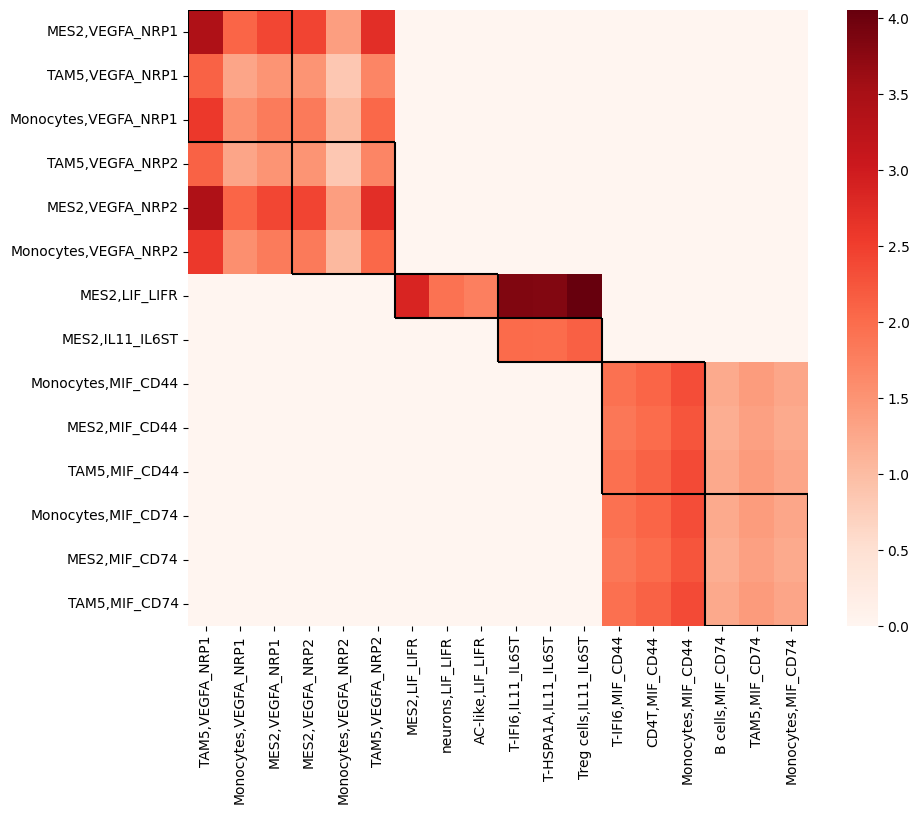

In [35]:
plt.figure(figsize=(10,8))
sns.heatmap(ER1_merge_triangle,cmap='Reds')
record_row = 0
record_col = 0
for k in range(len(row_gap_list)):
    plt.hlines(y=record_row+row_gap_list[k],xmin=record_col,xmax=record_col+col_gap_list[k],colors='black')
    plt.hlines(y=record_row,xmin=record_col,xmax=record_col+col_gap_list[k],colors='black')
    plt.vlines(x=record_col+col_gap_list[k],ymin=record_row,ymax=record_row+row_gap_list[k],colors='black')
    plt.vlines(x=record_col,ymin=record_row,ymax=record_row+row_gap_list[k],colors='black')
    record_row = record_row + row_gap_list[k]
    record_col = record_col + col_gap_list[k]

In [41]:
'ER2 ligand expression'

ER2_ligand = list(set([ item.split('_')[0] for item in ER2_four_quadrant.loc[ER2_four_quadrant['pathway'].isin(['COLLAGEN','LAMININ','TGFb','THBS','NOTCH','FN1','PDGF','SEMA3','ACTIVIN',\
                                                                                                               'HSPG','INSULIN','ANGPT','EDN','VEGF'])].index]))
exp_dataframe = pd.DataFrame(index= ER2_ligand
                             ,columns=['MES1','MES2','AC-like','NPC-like','OPC-like','neurons','Oligodendrocyte','Endo','Pericyte','VSMCs','TAM1','TAM2','TAM3','TAM4','TAM5','Monocytes','DC cells',
                   'NK cells','T-IFI6','Cytotoxic CD8T','Exhausted CD8T','T-HSPA1A','CD4T','Treg cells','B cells','Plasma cells'] )

def upper_genes(cluster):
    ratio = 0.20
    cells = meta_data.loc[meta_data['annotation'] == cluster].index.tolist()
    cutoff=  int(len(cells)*ratio)
    record = []
    select_norm = norm.loc[cells]
        
    for gene in exp_dataframe.index:
        record.append( np.mean(select_norm.sort_values(gene,ascending=False)[gene][:cutoff] ) )
    return record

pool = Pool(25)
k = pool.map(upper_genes, exp_dataframe.columns.tolist() )
pool.close()
pool.join()

exp_dataframe = pd.DataFrame(k,columns=exp_dataframe.index ,index= exp_dataframe.columns).T
exp_dataframe_refine = pd.DataFrame(index=exp_dataframe.index, columns=exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in exp_dataframe_refine.index:
    record = []
    for cluster in exp_dataframe_refine.columns:
        if cluster in ['MES1']:
            if MES1_STME2_ratio <= ratio_cutoff:
                #record.append( exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( exp_dataframe.loc[gene][cluster] * MES1_STME2_ratio )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME2_ratio <= ratio_cutoff:
                #record.append( exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( exp_dataframe.loc[gene][cluster] * MES2_STME2_ratio )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME2_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                #record.append( exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( exp_dataframe.loc[gene][cluster] * (STME2_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
    
    exp_dataframe_refine.loc[gene] = record

exp_dataframe_zscore = pd.DataFrame(index = exp_dataframe_refine.index,columns= exp_dataframe_refine.columns)
for gene in exp_dataframe_refine.index:
    exp_dataframe_zscore.loc[gene] = stats.zscore(exp_dataframe_refine.loc[gene].tolist())
    
exp_dataframe_zscore[list(exp_dataframe_zscore.columns)]=exp_dataframe_zscore[list(exp_dataframe_zscore.columns)].astype(float)

<AxesSubplot:>

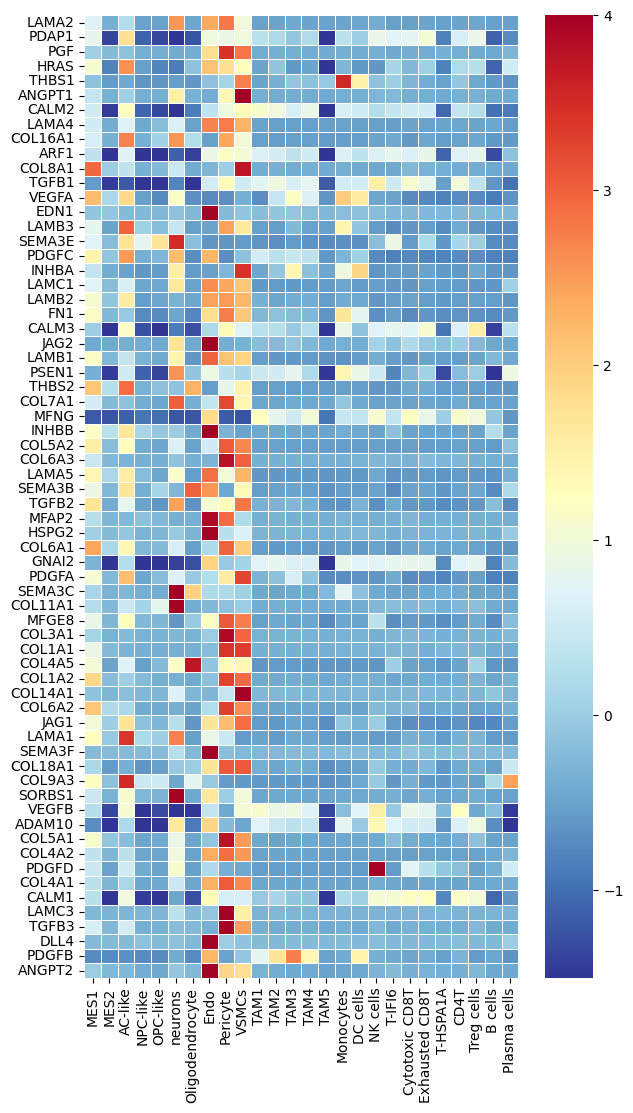

In [42]:
plt.figure(figsize=(7,12.5))
sns.heatmap(exp_dataframe_zscore,vmax=4,vmin=-1.5,cmap='RdYlBu_r',linewidths=0.50)

In [43]:
'ER2 receptor expression'
ER2_receptor = list(set([ item.split('_')[1] for item in ER2_four_quadrant.loc[ER2_four_quadrant['pathway'].isin(['COLLAGEN','LAMININ','TGFb','THBS','NOTCH','FN1','PDGF','SEMA3','ACTIVIN',\
                                                                                                               'HSPG','INSULIN','ANGPT','EDN','VEGF'])].index]))

record = []
for item in ER2_receptor:
    if item in norm.columns:
        record.append(item)
ER2_receptor = record

receptor_exp_dataframe = pd.DataFrame(index= ER2_receptor
                                      
                                      ,columns=['MES1','MES2','AC-like','NPC-like','OPC-like','neurons','Oligodendrocyte','Endo','Pericyte','VSMCs','TAM1','TAM2','TAM3','TAM4','TAM5','Monocytes','DC cells',
                   'NK cells','T-IFI6','Cytotoxic CD8T','Exhausted CD8T','T-HSPA1A','CD4T','Treg cells','B cells','Plasma cells'] )

def upper_genes(cluster):
    ratio = 0.20
    cells = meta_data.loc[meta_data['annotation'] == cluster].index.tolist()
    cutoff=  int(len(cells)*ratio)
    record = []
    select_norm = norm.loc[cells]
        
    for gene in receptor_exp_dataframe.index:
        record.append( np.mean(select_norm.sort_values(gene,ascending=False)[gene][:cutoff] ) )
        
    return record

pool = Pool(25)
k = pool.map(upper_genes, receptor_exp_dataframe.columns.tolist() )
pool.close()
pool.join()

receptor_exp_dataframe = pd.DataFrame(k,columns=receptor_exp_dataframe.index ,index= receptor_exp_dataframe.columns).T

receptor_exp_dataframe_refine = pd.DataFrame(index=receptor_exp_dataframe.index, columns=receptor_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in receptor_exp_dataframe_refine.index:
    record = []
    for cluster in receptor_exp_dataframe_refine.columns:
        if cluster in ['MES1']:
            if MES1_STME2_ratio <= ratio_cutoff:
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( receptor_exp_dataframe.loc[gene][cluster] * MES1_STME2_ratio )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME2_ratio <= ratio_cutoff:
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( receptor_exp_dataframe.loc[gene][cluster] * MES2_STME2_ratio )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME2_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * (STME2_ratio/c2l_average_table.max(axis=1))[cluster] )
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )

    receptor_exp_dataframe_refine.loc[gene] = record

receptor_exp_dataframe_refine_zscore = pd.DataFrame(index = receptor_exp_dataframe_refine.index,columns= receptor_exp_dataframe_refine.columns)
for gene in receptor_exp_dataframe_refine.index:
    receptor_exp_dataframe_refine_zscore.loc[gene] = stats.zscore(receptor_exp_dataframe_refine.loc[gene].tolist())
    
receptor_exp_dataframe_refine_zscore[list(receptor_exp_dataframe_refine_zscore.columns)]=receptor_exp_dataframe_refine_zscore[list(receptor_exp_dataframe_refine_zscore.columns)].astype(float)
receptor_exp_dataframe_refine[list(receptor_exp_dataframe_refine.columns)]=receptor_exp_dataframe_refine[list(receptor_exp_dataframe_refine.columns)].astype(float)

<AxesSubplot:>

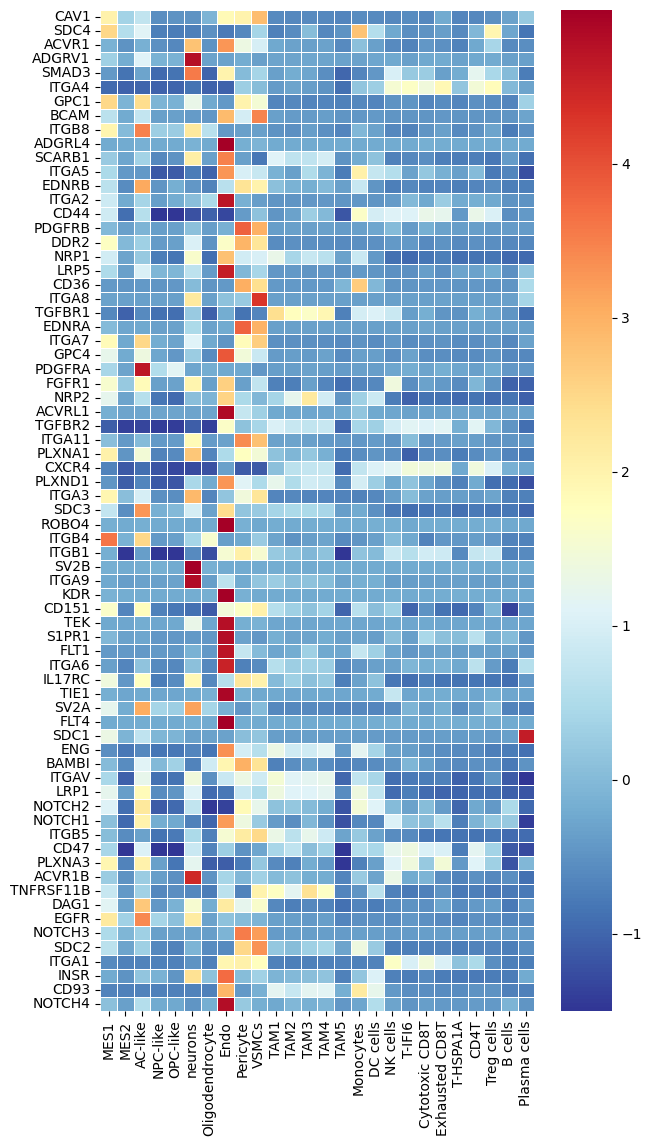

In [49]:
plt.figure(figsize=(7,13))
sns.heatmap(receptor_exp_dataframe_refine_zscore,cmap='RdYlBu_r',linewidths=0.50,vmin=-1.5)

In [51]:
'norm to 0-1'
exp_dataframe_refine_scale = pd.DataFrame(index=exp_dataframe_refine.index,columns=exp_dataframe_refine.columns)
for ligand in exp_dataframe_refine_scale.index:
    exp_dataframe_refine_scale.loc[ligand] = NormalizeData(exp_dataframe_refine.loc[ligand])

receptor_exp_dataframe_refine_scale = pd.DataFrame(index= receptor_exp_dataframe_refine.index, columns= receptor_exp_dataframe_refine.columns)
for receptor in receptor_exp_dataframe_refine_scale.index:
    receptor_exp_dataframe_refine_scale.loc[receptor] = NormalizeData(receptor_exp_dataframe_refine.loc[receptor])

In [54]:
'downsampling'
ER2_LR_pairs_list = ['COL1A1_ITGA1','COL1A1_CD36','COL1A2_ITGA1','COL1A2_ITGB1','COL5A1_ITGA1','COL5A1_ITGB1','COL5A2_ITGA1','COL6A1_ITGA1','COL6A2_ITGA1','COL8A1_ITGA1',\
                     'LAMA1_ITGA1',
                     'TGFB2_ENG','TGFB3_TGFBR2',
                     'THBS2_CD36','THBS2_NOTCH3',
                     'MFAP2_NOTCH1',
                     'FN1_FLT4',
                     'HSPG2_ITGB1',
                     'ANGPT1_TIE1','ANGPT2_TIE1',
                     'EDN1_EDNRA',
                     'VEGFA_FLT1']

In [55]:
record = []
for item in ER2_LR_pairs_list:
    if (item.split('_')[0] in norm.columns.tolist()) & (item.split('_')[1] in norm.columns.tolist()):
        record.append(item)
ER2_LR_pairs_list = record

In [56]:
ER2_Triangle_list = []
ER2_Triangle_list_raw = []
for LR_pairs in ER2_LR_pairs_list:
    Triangle = pd.DataFrame(index= exp_dataframe_zscore.columns, columns= exp_dataframe_zscore.columns)

    for cluster in Triangle.index:
        for item in Triangle.columns:
            Triangle.loc[cluster][item] = exp_dataframe_refine.loc[LR_pairs.split('_')[0]].loc[cluster] * receptor_exp_dataframe_refine.loc[LR_pairs.split('_')[1]].loc[item]
    Triangle[list(Triangle.columns)]=Triangle[list(Triangle.columns)].astype(float)

    'downsampling'
    Top3_ligand_clust = exp_dataframe_refine.loc[LR_pairs.split('_')[0]].sort_values(ascending=False).index[:3]
    Top3_receptor_clust = receptor_exp_dataframe_refine.loc[LR_pairs.split('_')[1]].sort_values(ascending=False).index[:3]
    
    filter_Triangle = Triangle.loc[Top3_ligand_clust][Top3_receptor_clust]
    
    filter_Triangle[list(filter_Triangle.columns)]=filter_Triangle[list(filter_Triangle.columns)].astype(float)
    
    filter_Triangle.index = [ item + ',' + LR_pairs for item in filter_Triangle.index]
    filter_Triangle.columns = [ item + ',' + LR_pairs for item in filter_Triangle.columns]

    'downsampling'
    cut_limit = 0.3
    
    'row'
    row_filter = filter_Triangle.index[np.sum(filter_Triangle,axis=1) >= np.max(np.sum(filter_Triangle,axis=1)) * cut_limit].tolist()
    'col'
    col_filter = filter_Triangle.columns[np.sum(filter_Triangle,axis=0) >= np.max(np.sum(filter_Triangle,axis=0)) * 0.5].tolist()
    
    if len(col_filter) == 1:
        row_filter = filter_Triangle.index[np.sum(filter_Triangle,axis=1) >= np.max(np.sum(filter_Triangle,axis=1)) * 1.0].tolist()
    
    filter_Triangle = filter_Triangle.loc[row_filter]
    filter_Triangle = filter_Triangle[col_filter]
   
    'random'
    random_index = filter_Triangle.index.tolist()
    random_columns = filter_Triangle.columns.tolist()
    random.shuffle(random_index)
    random.shuffle(random_columns)
    filter_Triangle = filter_Triangle.loc[random_index][random_columns]
    
    Triangle.index = [ item + ',' + LR_pairs for item in Triangle.index]
    Triangle.columns = [ item + ',' + LR_pairs for item in Triangle.columns]
    
    ER2_Triangle_list_raw.append(Triangle)
    ER2_Triangle_list.append(filter_Triangle

In [58]:
index_list = []
column_list = []
for item in ER2_Triangle_list:
    index_list = index_list + item.index.tolist()
    column_list = column_list + item.columns.tolist()

ER2_merge_triangle = pd.DataFrame(index= index_list, columns=column_list)

In [59]:
def ER2_cal(var):
    record = []
    for k in ER2_merge_triangle.columns:
        LR = var.split(',')[1].split('_')[0] +'_' + k.split(',')[1].split('_')[1]
        #rank = ER1_LR_pairs_list.index(LR)
        ligand = LR.split('_')[0]
        receptor = LR.split('_')[1]
        if LR not in Interaction_strength.columns.tolist():
            record.append(0)
        else:
            ratio = np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] == 'STME-2'].index ]) / np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] != 'STME-2'].index ]) 
            record.append(exp_dataframe_refine_scale.loc[ligand][var.split(',')[0]] * receptor_exp_dataframe_refine_scale.loc[receptor][k.split(',')[0]] * ratio)
    return record
            

In [60]:
pool = Pool(100)
k = pool.map(ER2_cal, ER2_merge_triangle.index.tolist())
pool.close()
pool.join()

In [65]:
ER2_merge_triangle = pd.DataFrame(k,index=ER2_merge_triangle.index,columns=ER2_merge_triangle.columns)
ER2_merge_triangle[list(ER2_merge_triangle.columns)]=ER2_merge_triangle[list(ER2_merge_triangle.columns)].astype(float)

exp_dataframe_refine_scale_STME_2 = exp_dataframe_refine_scale
receptor_exp_dataframe_refine_scale_STME_2 = receptor_exp_dataframe_refine_scale

row_gap_list = [ item.shape[0] for item in ER2_Triangle_list]
col_gap_list = [ item.shape[1] for item in ER2_Triangle_list]

In [66]:
clust_colors = {'TAM1':'#17728C','TAM2':'#C1EDF6','TAM3':'#C5E5BD','TAM4':'#89CFC5','TAM5':'#AA5FAC','Monocytes':'#748EBF','DC cells':'#00C8FB',\
                'Oligodendrocyte':'#AE958C',\
                'B cells':'#ECD157', 'Plasma cells':'#DABB57',\
                'Treg cells':'#fc912a','T-IFI6':'#FF6666',\
                'Cytotoxic CD8T':'#FD9DC6','Exhausted CD8T':'#eedce4',\
                'CD4T':'#FFB3A1','T-HSPA1A':'#FFD9CE',\
                'NK cells':'#FF3D73',\
                'MES1':'#4169E1','MES2':'#D7008C','AC-like':'#FED100','OPC-like':'#00A555','NPC-like':'#16CB55',\
                'neurons':'#4C8266',\
                'Pericyte':'#C83726','VSMCs':'#922226','Endo':'#F51F1A'}

color_list = [ clust_colors[item.split(',')[0]] for item in ER2_merge_triangle.index]

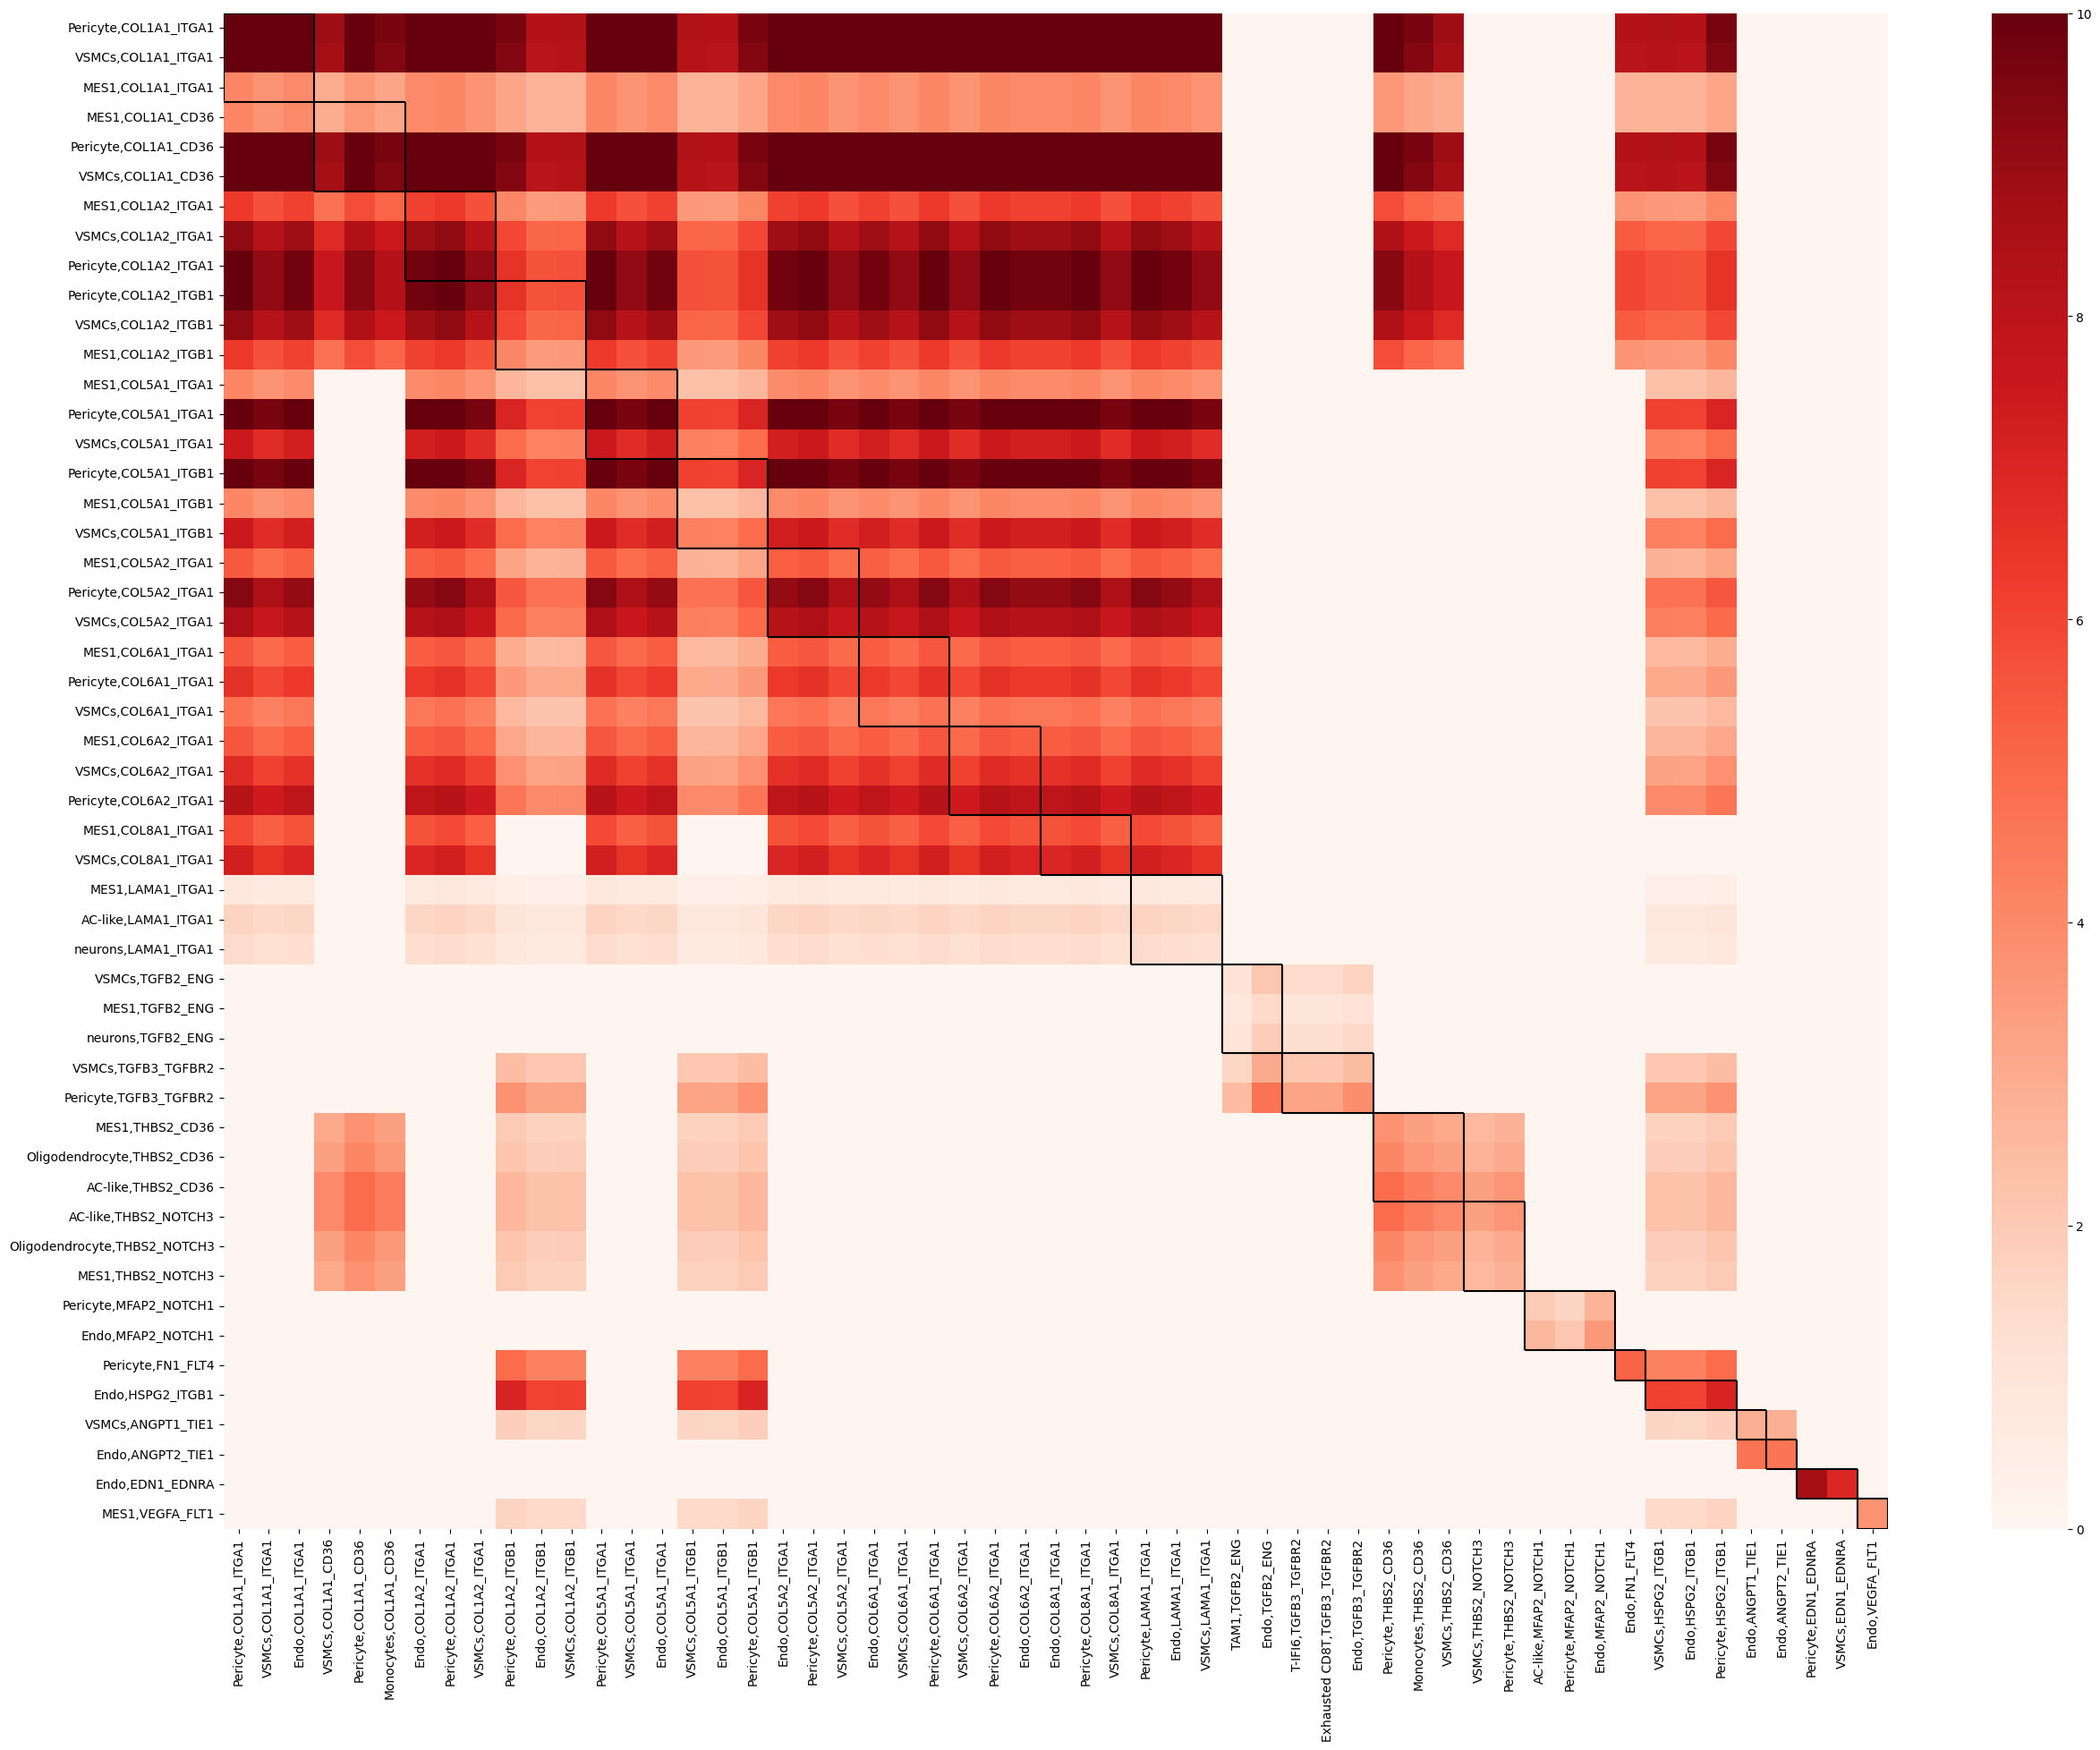

In [68]:
plt.figure(figsize=(30,22))
sns.heatmap(ER2_merge_triangle,cmap='Reds',vmax=10)
record_row = 0
record_col = 0
for k in range(len(row_gap_list)):
    plt.hlines(y=record_row+row_gap_list[k],xmin=record_col,xmax=record_col+col_gap_list[k],colors='black')
    plt.hlines(y=record_row,xmin=record_col,xmax=record_col+col_gap_list[k],colors='black')
    plt.vlines(x=record_col+col_gap_list[k],ymin=record_row,ymax=record_row+row_gap_list[k],colors='black')
    plt.vlines(x=record_col,ymin=record_row,ymax=record_row+row_gap_list[k],colors='black')
    record_row = record_row + row_gap_list[k]
    record_col = record_col + col_gap_list[k]

In [74]:
'ER3 ligand expression'
ER3_ligand = list(set([ item.split('_')[0] for item in ER3_four_quadrant.loc[ER3_four_quadrant['pathway'].isin(['NRXN','EPHB','SEMA6','GDF'])].index]))
exp_dataframe = pd.DataFrame(index= ER3_ligand
                             ,columns=['MES1','MES2','AC-like','NPC-like','OPC-like','neurons','Oligodendrocyte','Endo','Pericyte','VSMCs','TAM1','TAM2','TAM3','TAM4','TAM5','Monocytes','DC cells',
                   'NK cells','T-IFI6','Cytotoxic CD8T','Exhausted CD8T','T-HSPA1A','CD4T','Treg cells','B cells','Plasma cells'] )

def upper_genes(cluster):
    ratio = 0.20
    cells = meta_data.loc[meta_data['annotation'] == cluster].index.tolist()
    cutoff=  int(len(cells)*ratio)
    record = []
    select_norm = norm.loc[cells]
        
    for gene in exp_dataframe.index:
        record.append( np.mean(select_norm.sort_values(gene,ascending=False)[gene][:cutoff] ) )
    return record

pool = Pool(25)
k = pool.map(upper_genes, exp_dataframe.columns.tolist() )
pool.close()
pool.join()

exp_dataframe = pd.DataFrame(k,columns=exp_dataframe.index ,index= exp_dataframe.columns).T
exp_dataframe_refine = pd.DataFrame(index=exp_dataframe.index, columns=exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in exp_dataframe_refine.index:
    record = []
    for cluster in exp_dataframe_refine.columns:
        if cluster in ['MES1']:
            if MES1_STME3_ratio <= ratio_cutoff:
                #record.append( exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( exp_dataframe.loc[gene][cluster] * MES1_STME3_ratio )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME3_ratio <= ratio_cutoff:
                #record.append( exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( exp_dataframe.loc[gene][cluster] * MES2_STME3_ratio )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME3_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                #record.append( exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( exp_dataframe.loc[gene][cluster] * (STME3_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
    
    exp_dataframe_refine.loc[gene] = record

exp_dataframe_zscore = pd.DataFrame(index = exp_dataframe_refine.index,columns= exp_dataframe_refine.columns)
for gene in exp_dataframe_refine.index:
    exp_dataframe_zscore.loc[gene] = stats.zscore(exp_dataframe_refine.loc[gene].tolist())
    
exp_dataframe_zscore[list(exp_dataframe_zscore.columns)]=exp_dataframe_zscore[list(exp_dataframe_zscore.columns)].astype(float)

<AxesSubplot:>

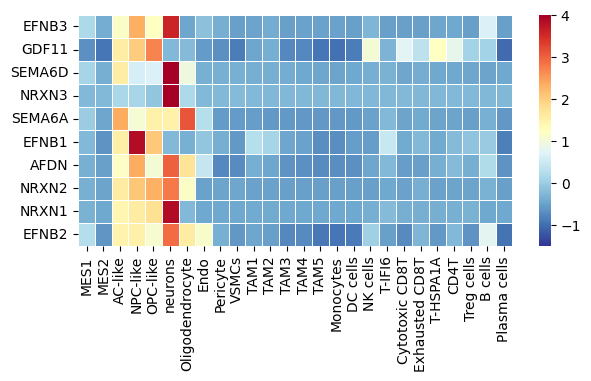

In [75]:
plt.figure(figsize=(7,3))
sns.heatmap(exp_dataframe_zscore,vmax=4,vmin=-1.5,cmap='RdYlBu_r',linewidths=0.50)

In [81]:
'ER3 receptor expression'
ER3_receptor = list(set([ item.split('_')[1] for item in ER3_four_quadrant.loc[ER3_four_quadrant['pathway'].isin(['NRXN','EPHB','SEMA6','GDF'])].index]))

record = []
for item in ER3_receptor:
    if item in norm.columns:
        record.append(item)
ER3_receptor = record

receptor_exp_dataframe = pd.DataFrame(index= ER3_receptor,
                                      columns=['MES1','MES2','AC-like','NPC-like','OPC-like','neurons','Oligodendrocyte','Endo','Pericyte','VSMCs','TAM1','TAM2','TAM3','TAM4','TAM5','Monocytes','DC cells',
                   'NK cells','T-IFI6','Cytotoxic CD8T','Exhausted CD8T','T-HSPA1A','CD4T','Treg cells','B cells','Plasma cells'] )

def upper_genes(cluster):
    ratio = 0.20
    cells = meta_data.loc[meta_data['annotation'] == cluster].index.tolist()
    cutoff=  int(len(cells)*ratio)
    record = []
    select_norm = norm.loc[cells]
        
    for gene in receptor_exp_dataframe.index:
        record.append( np.mean(select_norm.sort_values(gene,ascending=False)[gene][:cutoff] ) )
        
    return record

pool = Pool(25)
k = pool.map(upper_genes, receptor_exp_dataframe.columns.tolist() )
pool.close()
pool.join()
receptor_exp_dataframe = pd.DataFrame(k,columns=receptor_exp_dataframe.index ,index= receptor_exp_dataframe.columns).T

receptor_exp_dataframe_refine = pd.DataFrame(index=receptor_exp_dataframe.index, columns=receptor_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in receptor_exp_dataframe_refine.index:
    record = []
    for cluster in receptor_exp_dataframe_refine.columns:
        if cluster in ['MES1']:
            if MES1_STME3_ratio <= ratio_cutoff:
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( receptor_exp_dataframe.loc[gene][cluster] * MES1_STME3_ratio )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME3_ratio <= ratio_cutoff:
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( receptor_exp_dataframe.loc[gene][cluster] * MES2_STME3_ratio )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME3_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * (STME3_ratio/c2l_average_table.max(axis=1))[cluster] )
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )

    receptor_exp_dataframe_refine.loc[gene] = record

receptor_exp_dataframe_refine_zscore = pd.DataFrame(index = receptor_exp_dataframe_refine.index,columns= receptor_exp_dataframe_refine.columns)
for gene in receptor_exp_dataframe_refine.index:
    receptor_exp_dataframe_refine_zscore.loc[gene] = stats.zscore(receptor_exp_dataframe_refine.loc[gene].tolist())
    
receptor_exp_dataframe_refine_zscore[list(receptor_exp_dataframe_refine_zscore.columns)]=receptor_exp_dataframe_refine_zscore[list(receptor_exp_dataframe_refine_zscore.columns)].astype(float)
receptor_exp_dataframe_refine[list(receptor_exp_dataframe_refine.columns)]=receptor_exp_dataframe_refine[list(receptor_exp_dataframe_refine.columns)].astype(float)

<AxesSubplot:>

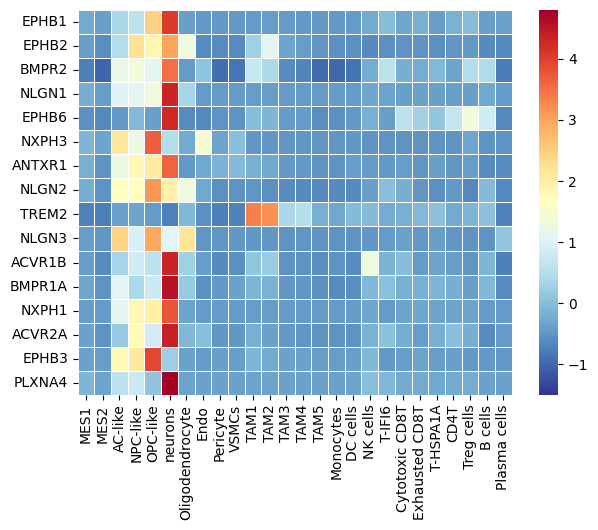

In [82]:
plt.figure(figsize=(7,5))
sns.heatmap(receptor_exp_dataframe_refine_zscore,cmap='RdYlBu_r',linewidths=0.50,vmin=-1.5)

In [84]:
'norm to 0-1'
exp_dataframe_refine_scale = pd.DataFrame(index=exp_dataframe_refine.index,columns=exp_dataframe_refine.columns)
for ligand in exp_dataframe_refine_scale.index:
    exp_dataframe_refine_scale.loc[ligand] = NormalizeData(exp_dataframe_refine.loc[ligand])

receptor_exp_dataframe_refine_scale = pd.DataFrame(index= receptor_exp_dataframe_refine.index, columns= receptor_exp_dataframe_refine.columns)
for receptor in receptor_exp_dataframe_refine_scale.index:
    receptor_exp_dataframe_refine_scale.loc[receptor] = NormalizeData(receptor_exp_dataframe_refine.loc[receptor])

In [87]:
'downsampling'
ER3_LR_pairs_list = ['NRXN1_NLGN1','NRXN1_NLGN2','NRXN1_NLGN3','NRXN2_NLGN3','NRXN3_NXPH1','EFNB3_EPHB1','EFNB3_EPHB2','EFNB3_EPHB3','GDF11_ACVR1B','GDF11_ACVR2A','GDF11_BMPR1A']

record = []
for item in ER3_LR_pairs_list:
    if (item.split('_')[0] in norm.columns.tolist()) & (item.split('_')[1] in norm.columns.tolist()):
        record.append(item)
ER3_LR_pairs_list = record

In [88]:
ER3_Triangle_list = []
ER3_Triangle_list_raw = []
for LR_pairs in ER3_LR_pairs_list:
    Triangle = pd.DataFrame(index= exp_dataframe_zscore.columns, columns= exp_dataframe_zscore.columns)

    for cluster in Triangle.index:
        for item in Triangle.columns:
            Triangle.loc[cluster][item] = exp_dataframe_refine.loc[LR_pairs.split('_')[0]].loc[cluster] * receptor_exp_dataframe_refine.loc[LR_pairs.split('_')[1]].loc[item]
    Triangle[list(Triangle.columns)]=Triangle[list(Triangle.columns)].astype(float)

    'downsampling'
    Top2_ligand_clust = exp_dataframe_refine.loc[LR_pairs.split('_')[0]].sort_values(ascending=False).index[:2]
    Top2_receptor_clust = receptor_exp_dataframe_refine.loc[LR_pairs.split('_')[1]].sort_values(ascending=False).index[:2]
    
    filter_Triangle = Triangle.loc[Top2_ligand_clust][Top2_receptor_clust]
    
    filter_Triangle[list(filter_Triangle.columns)]=filter_Triangle[list(filter_Triangle.columns)].astype(float)
    
    filter_Triangle.index = [ item + ',' + LR_pairs for item in filter_Triangle.index]
    filter_Triangle.columns = [ item + ',' + LR_pairs for item in filter_Triangle.columns]
    
    'downsampling'
    cut_limit = 0.3
    
    'row'
    row_filter = filter_Triangle.index[np.sum(filter_Triangle,axis=1) >= np.max(np.sum(filter_Triangle,axis=1)) * 0.75].tolist()
    'col'
    col_filter = filter_Triangle.columns[np.sum(filter_Triangle,axis=0) >= np.max(np.sum(filter_Triangle,axis=0)) * 0.75].tolist()
    
    if len(col_filter) == 1:
        row_filter = filter_Triangle.index[np.sum(filter_Triangle,axis=1) >= np.max(np.sum(filter_Triangle,axis=1)) * 1].tolist()
    
    filter_Triangle = filter_Triangle.loc[row_filter]
    filter_Triangle = filter_Triangle[col_filter]
   
    'random'
    random_index = filter_Triangle.index.tolist()
    random_columns = filter_Triangle.columns.tolist()
    random.shuffle(random_index)
    random.shuffle(random_columns)
    filter_Triangle = filter_Triangle.loc[random_index][random_columns]
    
    Triangle.index = [ item + ',' + LR_pairs for item in Triangle.index]
    Triangle.columns = [ item + ',' + LR_pairs for item in Triangle.columns]
    
    ER3_Triangle_list_raw.append(Triangle)
    ER3_Triangle_list.append(filter_Triangle)

In [89]:
index_list = []
column_list = []
for item in ER3_Triangle_list:
    index_list = index_list + item.index.tolist()
    column_list = column_list + item.columns.tolist()

In [90]:
ER3_merge_triangle = pd.DataFrame(index= index_list, columns=column_list)

for item in ER3_merge_triangle.index:
    for k in ER3_merge_triangle.columns:
        LR = item.split(',')[1].split('_')[0] +'_' + k.split(',')[1].split('_')[1]
        ligand = LR.split('_')[0]
        receptor = LR.split('_')[1]
        if LR not in Interaction_strength.columns.tolist():
            ER3_merge_triangle.loc[item][k] = 0
        else:
            ratio = np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] == 'STME-3'].index ]) / np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] != 'STME-3'].index ]) 
            ER3_merge_triangle.loc[item][k] = exp_dataframe_refine_scale.loc[ligand][item.split(',')[0]] * receptor_exp_dataframe_refine_scale.loc[receptor][k.split(',')[0]] * ratio
    
ER3_merge_triangle[list(ER3_merge_triangle.columns)]=ER3_merge_triangle[list(ER3_merge_triangle.columns)].astype(float)


In [94]:
ER3_merge_triangle_scale = pd.DataFrame(index=ER3_merge_triangle.index,columns=ER3_merge_triangle.columns)

for item in ER3_merge_triangle_scale.index:
    if np.sum(ER3_merge_triangle.loc[item]) == 0:
        ER3_merge_triangle_scale.loc[item] = ER3_merge_triangle.loc[item]
    else:
        ER3_merge_triangle_scale.loc[item] =  NormalizeData(ER3_merge_triangle.loc[item])

ER3_merge_triangle[list(ER3_merge_triangle.columns)]=ER3_merge_triangle[list(ER3_merge_triangle.columns)].astype(float)

exp_dataframe_refine_scale_STME_3 = exp_dataframe_refine_scale
receptor_exp_dataframe_refine_scale_STME_3 = receptor_exp_dataframe_refine_scale

In [95]:
row_gap_list = [ item.shape[0] for item in ER3_Triangle_list]
col_gap_list = [ item.shape[1] for item in ER3_Triangle_list]

In [96]:
clust_colors = {'TAM1':'#17728C','TAM2':'#C1EDF6','TAM3':'#C5E5BD','TAM4':'#89CFC5','TAM5':'#AA5FAC','Monocytes':'#748EBF','DC cells':'#00C8FB',\
                'Oligodendrocyte':'#AE958C',\
                'B cells':'#ECD157', 'Plasma cells':'#DABB57',\
                'Treg cells':'#fc912a','T-IFI6':'#FF6666',\
                'Cytotoxic CD8T':'#FD9DC6','Exhausted CD8T':'#eedce4',\
                'CD4T':'#FFB3A1','T-HSPA1A':'#FFD9CE',\
                'NK cells':'#FF3D73',\
                'MES1':'#4169E1','MES2':'#D7008C','AC-like':'#FED100','OPC-like':'#00A555','NPC-like':'#16CB55',\
                'neurons':'#4C8266',\
                'Pericyte':'#C83726','VSMCs':'#922226','Endo':'#F51F1A'}
color_list = [ clust_colors[item.split(',')[0]] for item in ER3_merge_triangle_scale.index]

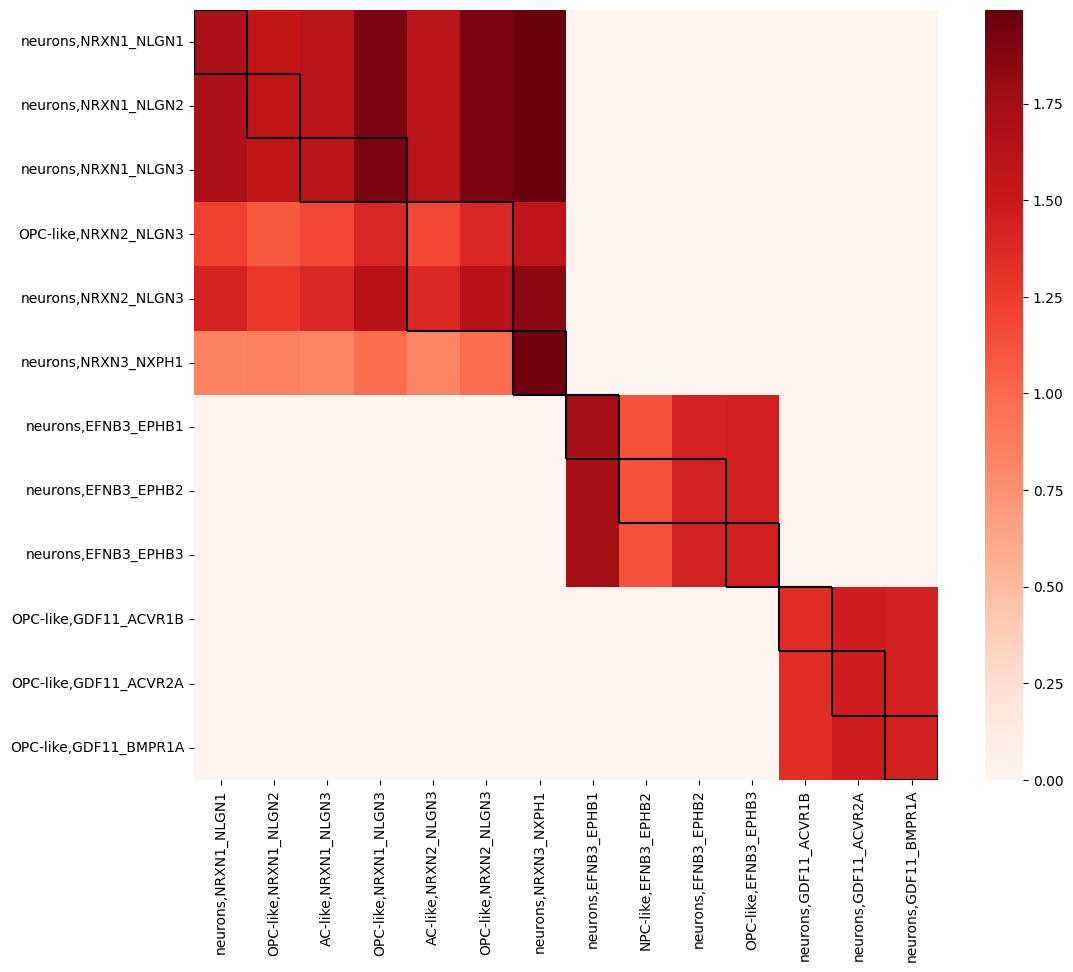

In [98]:
plt.figure(figsize=(12,10))
sns.heatmap(ER3_merge_triangle,cmap='Reds')
record_row = 0
record_col = 0
for k in range(len(row_gap_list)):
    plt.hlines(y=record_row+row_gap_list[k],xmin=record_col,xmax=record_col+col_gap_list[k],colors='black')
    plt.hlines(y=record_row,xmin=record_col,xmax=record_col+col_gap_list[k],colors='black')
    plt.vlines(x=record_col+col_gap_list[k],ymin=record_row,ymax=record_row+row_gap_list[k],colors='black')
    plt.vlines(x=record_col,ymin=record_row,ymax=record_row+row_gap_list[k],colors='black')
    record_row = record_row + row_gap_list[k]
    record_col = record_col + col_gap_list[k]

In [104]:
'ER4 ligand expression'
ER4_ligand = list(set([ item.split('_')[0] for item in ER4_four_quadrant.loc[ER4_four_quadrant['pathway'].isin(['PTN','COLLAGEN'])].index]))
exp_dataframe = pd.DataFrame(index= ER4_ligand
                             ,columns=['MES1','MES2','AC-like','NPC-like','OPC-like','neurons','Oligodendrocyte','Endo','Pericyte','VSMCs','TAM1','TAM2','TAM3','TAM4','TAM5','Monocytes','DC cells',
                   'NK cells','T-IFI6','Cytotoxic CD8T','Exhausted CD8T','T-HSPA1A','CD4T','Treg cells','B cells','Plasma cells'] )

def upper_genes(cluster):
    ratio = 0.20
    cells = meta_data.loc[meta_data['annotation'] == cluster].index.tolist()
    cutoff=  int(len(cells)*ratio)
    record = []
    select_norm = norm.loc[cells]
        
    for gene in exp_dataframe.index:
        record.append( np.mean(select_norm.sort_values(gene,ascending=False)[gene][:cutoff] ) )
    return record

pool = Pool(25)
k = pool.map(upper_genes, exp_dataframe.columns.tolist() )
pool.close()
pool.join()

exp_dataframe = pd.DataFrame(k,columns=exp_dataframe.index ,index= exp_dataframe.columns).T
exp_dataframe_refine = pd.DataFrame(index=exp_dataframe.index, columns=exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in exp_dataframe_refine.index:
    record = []
    for cluster in exp_dataframe_refine.columns:
        if cluster in ['MES1']:
            if MES1_STME4_ratio <= ratio_cutoff:
                #record.append( exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( exp_dataframe.loc[gene][cluster] * MES1_STME4_ratio )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME4_ratio <= ratio_cutoff:
                #record.append( exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( exp_dataframe.loc[gene][cluster] * MES2_STME4_ratio )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME4_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                #record.append( exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( exp_dataframe.loc[gene][cluster] * (STME4_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( exp_dataframe.loc[gene][cluster] * 1.0 )
    
    exp_dataframe_refine.loc[gene] = record

exp_dataframe_zscore = pd.DataFrame(index = exp_dataframe_refine.index,columns= exp_dataframe_refine.columns)
for gene in exp_dataframe_refine.index:
    exp_dataframe_zscore.loc[gene] = stats.zscore(exp_dataframe_refine.loc[gene].tolist())
    
exp_dataframe_zscore[list(exp_dataframe_zscore.columns)]=exp_dataframe_zscore[list(exp_dataframe_zscore.columns)].astype(float)

<AxesSubplot:>

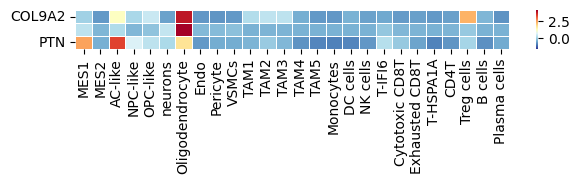

In [105]:
plt.figure(figsize=(7,0.5))
sns.heatmap(exp_dataframe_zscore,vmax=4,vmin=-1.5,cmap='RdYlBu_r',linewidths=0.50)

In [111]:
'ER4 receptor expression'
ER4_receptor = list(set([ item.split('_')[1] for item in ER4_four_quadrant.loc[ER4_four_quadrant['pathway'].isin(['PTN','COLLAGEN'])].index]))

record = []
for item in ER4_receptor:
    if item in norm.columns:
        record.append(item)
ER4_receptor = record

receptor_exp_dataframe = pd.DataFrame(index= ER4_receptor
                                      ,columns=['MES1','MES2','AC-like','NPC-like','OPC-like','neurons','Oligodendrocyte','Endo','Pericyte','VSMCs','TAM1','TAM2','TAM3','TAM4','TAM5','Monocytes','DC cells',
                   'NK cells','T-IFI6','Cytotoxic CD8T','Exhausted CD8T','T-HSPA1A','CD4T','Treg cells','B cells','Plasma cells'] )

def upper_genes(cluster):
    ratio = 0.20
    cells = meta_data.loc[meta_data['annotation'] == cluster].index.tolist()
    cutoff=  int(len(cells)*ratio)
    record = []
    select_norm = norm.loc[cells]
        
    for gene in receptor_exp_dataframe.index:
        record.append( np.mean(select_norm.sort_values(gene,ascending=False)[gene][:cutoff] ) )
    return record

pool = Pool(25)
k = pool.map(upper_genes, receptor_exp_dataframe.columns.tolist() )
pool.close()
pool.join()

receptor_exp_dataframe = pd.DataFrame(k,columns=receptor_exp_dataframe.index ,index= receptor_exp_dataframe.columns).T



receptor_exp_dataframe_refine = pd.DataFrame(index=receptor_exp_dataframe.index, columns=receptor_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in receptor_exp_dataframe_refine.index:
    record = []
    for cluster in receptor_exp_dataframe_refine.columns:
        if cluster in ['MES1']:
            if MES1_STME4_ratio <= ratio_cutoff:
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( receptor_exp_dataframe.loc[gene][cluster] * MES1_STME4_ratio )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME4_ratio <= ratio_cutoff:
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff)
                record.append( receptor_exp_dataframe.loc[gene][cluster] * MES2_STME4_ratio )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME4_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * (STME4_ratio/c2l_average_table.max(axis=1))[cluster] )
                #record.append( receptor_exp_dataframe.loc[gene][cluster] * ratio_cutoff )
            else:
                record.append( receptor_exp_dataframe.loc[gene][cluster] * 1.0 )

    receptor_exp_dataframe_refine.loc[gene] = record

receptor_exp_dataframe_refine_zscore = pd.DataFrame(index = receptor_exp_dataframe_refine.index,columns= receptor_exp_dataframe_refine.columns)
for gene in receptor_exp_dataframe_refine.index:
    receptor_exp_dataframe_refine_zscore.loc[gene] = stats.zscore(receptor_exp_dataframe_refine.loc[gene].tolist())
    
receptor_exp_dataframe_refine_zscore[list(receptor_exp_dataframe_refine_zscore.columns)]=receptor_exp_dataframe_refine_zscore[list(receptor_exp_dataframe_refine_zscore.columns)].astype(float)
receptor_exp_dataframe_refine[list(receptor_exp_dataframe_refine.columns)]=receptor_exp_dataframe_refine[list(receptor_exp_dataframe_refine.columns)].astype(float)

<AxesSubplot:>

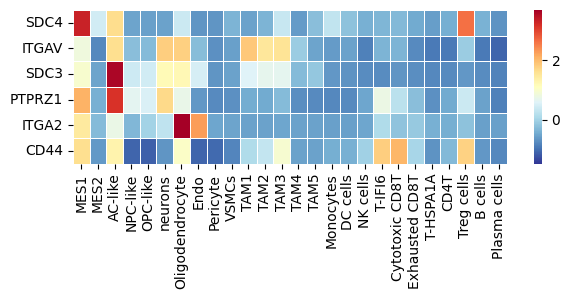

In [112]:
plt.figure(figsize=(7,2))
sns.heatmap(receptor_exp_dataframe_refine_zscore,cmap='RdYlBu_r',linewidths=0.50,vmin=-1.5)

In [114]:
'norm to 0-1'
exp_dataframe_refine_scale = pd.DataFrame(index=exp_dataframe_refine.index,columns=exp_dataframe_refine.columns)
for ligand in exp_dataframe_refine_scale.index:
    exp_dataframe_refine_scale.loc[ligand] = NormalizeData(exp_dataframe_refine.loc[ligand])
receptor_exp_dataframe_refine_scale = pd.DataFrame(index= receptor_exp_dataframe_refine.index, columns= receptor_exp_dataframe_refine.columns)
for receptor in receptor_exp_dataframe_refine_scale.index:
    receptor_exp_dataframe_refine_scale.loc[receptor] = NormalizeData(receptor_exp_dataframe_refine.loc[receptor])

In [119]:
'downsampling'
ER4_LR_pairs_list = ['PTN_SDC4','PTN_SDC3','PTN_PTPRZ1']

record = []
for item in ER4_LR_pairs_list:
    if (item.split('_')[0] in norm.columns.tolist()) & (item.split('_')[1] in norm.columns.tolist()):
        record.append(item)

ER4_LR_pairs_list = record

In [120]:
ER4_Triangle_list = []
ER4_Triangle_list_raw = []
for LR_pairs in ER4_LR_pairs_list:
    Triangle = pd.DataFrame(index= exp_dataframe_zscore.columns, columns= exp_dataframe_zscore.columns)

    for cluster in Triangle.index:
        for item in Triangle.columns:
            Triangle.loc[cluster][item] = exp_dataframe_refine.loc[LR_pairs.split('_')[0]].loc[cluster] * receptor_exp_dataframe_refine.loc[LR_pairs.split('_')[1]].loc[item]
    Triangle[list(Triangle.columns)]=Triangle[list(Triangle.columns)].astype(float)
    
    'downsampling'
    Top2_ligand_clust = exp_dataframe_refine.loc[LR_pairs.split('_')[0]].sort_values(ascending=False).index[:2]
    Top2_receptor_clust = receptor_exp_dataframe_refine.loc[LR_pairs.split('_')[1]].sort_values(ascending=False).index[:2]
    
    filter_Triangle = Triangle.loc[Top2_ligand_clust][Top2_receptor_clust]
    
    filter_Triangle[list(filter_Triangle.columns)]=filter_Triangle[list(filter_Triangle.columns)].astype(float)
    
    filter_Triangle.index = [ item + ',' + LR_pairs for item in filter_Triangle.index]
    filter_Triangle.columns = [ item + ',' + LR_pairs for item in filter_Triangle.columns]
    
    'downsampling'
    cut_limit = 0.5
    
    'row'
    row_filter = filter_Triangle.index[np.sum(filter_Triangle,axis=1) >= np.max(np.sum(filter_Triangle,axis=1)) * 0.5].tolist()
    'col'
    col_filter = filter_Triangle.columns[np.sum(filter_Triangle,axis=0) >= np.max(np.sum(filter_Triangle,axis=0)) * 0.5].tolist()
    
    if len(col_filter) == 1:
        row_filter = filter_Triangle.index[np.sum(filter_Triangle,axis=1) >= np.max(np.sum(filter_Triangle,axis=1)) * 1].tolist()
    
    filter_Triangle = filter_Triangle.loc[row_filter]
    filter_Triangle = filter_Triangle[col_filter]
   
    'random'
    random_index = filter_Triangle.index.tolist()
    random_columns = filter_Triangle.columns.tolist()
    random.shuffle(random_index)
    random.shuffle(random_columns)
    filter_Triangle = filter_Triangle.loc[random_index][random_columns]
    
    Triangle.index = [ item + ',' + LR_pairs for item in Triangle.index]
    Triangle.columns = [ item + ',' + LR_pairs for item in Triangle.columns]
    
    ER4_Triangle_list_raw.append(Triangle)
    ER4_Triangle_list.append(filter_Triangle)

In [121]:
index_list = []
column_list = []
for item in ER4_Triangle_list:
    index_list = index_list + item.index.tolist()
    column_list = column_list + item.columns.tolist()

In [122]:
ER4_merge_triangle = pd.DataFrame(index= index_list, columns=column_list)

for item in ER4_merge_triangle.index:
    for k in ER4_merge_triangle.columns:
        LR = item.split(',')[1].split('_')[0] +'_' + k.split(',')[1].split('_')[1]
        #rank = ER1_LR_pairs_list.index(LR)
        ligand = LR.split('_')[0]
        receptor = LR.split('_')[1]
        if LR not in Interaction_strength.columns.tolist():
            ER4_merge_triangle.loc[item][k] = 0
        else:
            ratio = np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] == 'STME-4'].index ]) / np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] != 'STME-4'].index ]) 
            ER4_merge_triangle.loc[item][k] = exp_dataframe_refine_scale.loc[ligand][item.split(',')[0]] * receptor_exp_dataframe_refine_scale.loc[receptor][k.split(',')[0]] * ratio
    
ER4_merge_triangle[list(ER4_merge_triangle.columns)]=ER4_merge_triangle[list(ER4_merge_triangle.columns)].astype(float)


In [126]:
ER4_merge_triangle[list(ER4_merge_triangle.columns)]=ER4_merge_triangle[list(ER4_merge_triangle.columns)].astype(float)

exp_dataframe_refine_scale_STME_4 = exp_dataframe_refine_scale
receptor_exp_dataframe_refine_scale_STME_4 = receptor_exp_dataframe_refine_scale

row_gap_list = [ item.shape[0] for item in ER4_Triangle_list]
col_gap_list = [ item.shape[1] for item in ER4_Triangle_list]

In [127]:
clust_colors = {'TAM1':'#17728C','TAM2':'#C1EDF6','TAM3':'#C5E5BD','TAM4':'#89CFC5','TAM5':'#AA5FAC','Monocytes':'#748EBF','DC cells':'#00C8FB',\
                'Oligodendrocyte':'#AE958C',\
                'B cells':'#ECD157', 'Plasma cells':'#DABB57',\
                'Treg cells':'#fc912a','T-IFI6':'#FF6666',\
                'Cytotoxic CD8T':'#FD9DC6','Exhausted CD8T':'#eedce4',\
                'CD4T':'#FFB3A1','T-HSPA1A':'#FFD9CE',\
                'NK cells':'#FF3D73',\
                'MES1':'#4169E1','MES2':'#D7008C','AC-like':'#FED100','OPC-like':'#00A555','NPC-like':'#16CB55',\
                'neurons':'#4C8266',\
                'Pericyte':'#C83726','VSMCs':'#922226','Endo':'#F51F1A'}

In [128]:
color_list = [ clust_colors[item.split(',')[0]] for item in ER4_merge_triangle.index]

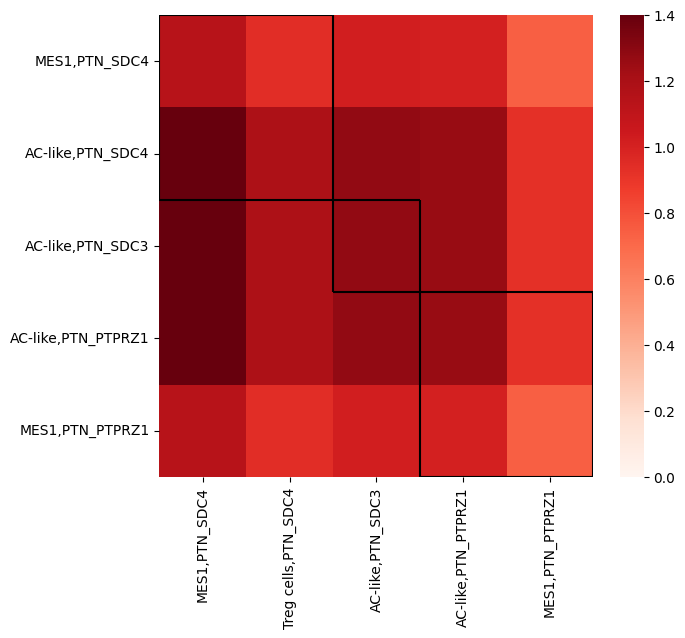

In [129]:
plt.figure(figsize=(7,6))
sns.heatmap(ER4_merge_triangle,cmap='Reds',vmin=0,vmax=1.4)
record_row = 0
record_col = 0
for k in range(len(row_gap_list)):
    plt.hlines(y=record_row+row_gap_list[k],xmin=record_col,xmax=record_col+col_gap_list[k],colors='black')
    plt.hlines(y=record_row,xmin=record_col,xmax=record_col+col_gap_list[k],colors='black')
    plt.vlines(x=record_col+col_gap_list[k],ymin=record_row,ymax=record_row+row_gap_list[k],colors='black')
    plt.vlines(x=record_col,ymin=record_row,ymax=record_row+row_gap_list[k],colors='black')
    record_row = record_row + row_gap_list[k]
    record_col = record_col + col_gap_list[k]

In [132]:
'merge ligand and receptor'
merge_ligand = list( set( exp_dataframe_refine_scale_STME_1.index.tolist() + exp_dataframe_refine_scale_STME_2.index.tolist() + exp_dataframe_refine_scale_STME_3.index.tolist() + exp_dataframe_refine_scale_STME_4.index.tolist() ) )
merge_receptor = list( set( receptor_exp_dataframe_refine_scale_STME_1.index.tolist() + receptor_exp_dataframe_refine_scale_STME_2.index.tolist() + receptor_exp_dataframe_refine_scale_STME_3.index.tolist() + receptor_exp_dataframe_refine_scale_STME_4.index.tolist() ) )    


In [133]:
merge_exp_dataframe = pd.DataFrame(index= merge_ligand
                             ,columns=['MES1','MES2','AC-like','NPC-like','OPC-like','neurons','Oligodendrocyte','Endo','Pericyte','VSMCs','TAM1','TAM2','TAM3','TAM4','TAM5','Monocytes','DC cells',
                   'NK cells','T-IFI6','Cytotoxic CD8T','Exhausted CD8T','T-HSPA1A','CD4T','Treg cells','B cells','Plasma cells'] )

In [134]:
def upper_genes(cluster):
    ratio = 0.20
    cells = meta_data.loc[meta_data['annotation'] == cluster].index.tolist()
    cutoff=  int(len(cells)*ratio)
    record = []
    select_norm = norm.loc[cells]
        
    for gene in merge_exp_dataframe.index:
        record.append( np.mean(select_norm.sort_values(gene,ascending=False)[gene][:cutoff] ) )
    return record

In [135]:
pool = Pool(25)
k = pool.map(upper_genes, merge_exp_dataframe.columns.tolist() )
pool.close()
pool.join()

In [136]:
merge_exp_dataframe = pd.DataFrame(k,columns=merge_exp_dataframe.index ,index= merge_exp_dataframe.columns).T
merge_exp_dataframe_refine_STME1 = pd.DataFrame(index=merge_exp_dataframe.index, columns=merge_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in merge_exp_dataframe_refine_STME1.index:
    record = []
    for cluster in merge_exp_dataframe_refine_STME1.columns:
        if cluster in ['MES1']:
            if MES1_STME1_ratio <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * MES1_STME1_ratio )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME1_ratio <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * MES2_STME1_ratio )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME1_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * (STME1_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
    
    merge_exp_dataframe_refine_STME1.loc[gene] = record

In [137]:
merge_exp_dataframe = pd.DataFrame(k,columns=merge_exp_dataframe.index ,index= merge_exp_dataframe.columns).T
merge_exp_dataframe_refine_STME2 = pd.DataFrame(index=merge_exp_dataframe.index, columns=merge_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in merge_exp_dataframe_refine_STME2.index:
    record = []
    for cluster in merge_exp_dataframe_refine_STME2.columns:
        if cluster in ['MES1']:
            if MES1_STME2_ratio <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * MES1_STME2_ratio )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME2_ratio <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * MES2_STME2_ratio )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME2_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * (STME2_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
    
    merge_exp_dataframe_refine_STME2.loc[gene] = record

In [138]:
merge_exp_dataframe = pd.DataFrame(k,columns=merge_exp_dataframe.index ,index= merge_exp_dataframe.columns).T
merge_exp_dataframe_refine_STME3 = pd.DataFrame(index=merge_exp_dataframe.index, columns=merge_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in merge_exp_dataframe_refine_STME3.index:
    record = []
    for cluster in merge_exp_dataframe_refine_STME3.columns:
        if cluster in ['MES1']:
            if MES1_STME3_ratio <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * MES1_STME3_ratio )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME3_ratio <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * MES2_STME3_ratio )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME3_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * (STME3_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
    
    merge_exp_dataframe_refine_STME3.loc[gene] = record

In [139]:
merge_exp_dataframe = pd.DataFrame(k,columns=merge_exp_dataframe.index ,index= merge_exp_dataframe.columns).T
merge_exp_dataframe_refine_STME4 = pd.DataFrame(index=merge_exp_dataframe.index, columns=merge_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in merge_exp_dataframe_refine_STME4.index:
    record = []
    for cluster in merge_exp_dataframe_refine_STME4.columns:
        if cluster in ['MES1']:
            if MES1_STME4_ratio <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * MES1_STME4_ratio )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME4_ratio <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * MES2_STME4_ratio )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME4_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( merge_exp_dataframe.loc[gene][cluster] * (STME4_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( merge_exp_dataframe.loc[gene][cluster] * 1.0 )
    
    merge_exp_dataframe_refine_STME4.loc[gene] = record

In [140]:
'norm to 0-1'
merge_exp_dataframe_refine_STME1_scale = pd.DataFrame(index=merge_exp_dataframe_refine_STME1.index,columns=merge_exp_dataframe_refine_STME1.columns)
merge_exp_dataframe_refine_STME2_scale = pd.DataFrame(index=merge_exp_dataframe_refine_STME2.index,columns=merge_exp_dataframe_refine_STME2.columns)
merge_exp_dataframe_refine_STME3_scale = pd.DataFrame(index=merge_exp_dataframe_refine_STME3.index,columns=merge_exp_dataframe_refine_STME3.columns)
merge_exp_dataframe_refine_STME4_scale = pd.DataFrame(index=merge_exp_dataframe_refine_STME4.index,columns=merge_exp_dataframe_refine_STME4.columns)

In [141]:
for gene in merge_exp_dataframe_refine_STME1_scale.index:
    entire_list = NormalizeData(merge_exp_dataframe_refine_STME1.loc[gene].tolist() + merge_exp_dataframe_refine_STME2.loc[gene].tolist() + merge_exp_dataframe_refine_STME3.loc[gene].tolist() + merge_exp_dataframe_refine_STME4.loc[gene].tolist() ) 
    
    merge_exp_dataframe_refine_STME1_scale.loc[gene] = entire_list[26*0:26*1]
    merge_exp_dataframe_refine_STME2_scale.loc[gene] = entire_list[26*1:26*2]
    merge_exp_dataframe_refine_STME3_scale.loc[gene] = entire_list[26*2:26*3]
    merge_exp_dataframe_refine_STME4_scale.loc[gene] = entire_list[26*3:26*4]

In [142]:
merge_receptor_exp_dataframe = pd.DataFrame(index= merge_receptor
                                      
                                      ,columns=['MES1','MES2','AC-like','NPC-like','OPC-like','neurons','Oligodendrocyte','Endo','Pericyte','VSMCs','TAM1','TAM2','TAM3','TAM4','TAM5','Monocytes','DC cells',
                   'NK cells','T-IFI6','Cytotoxic CD8T','Exhausted CD8T','T-HSPA1A','CD4T','Treg cells','B cells','Plasma cells'] )

In [143]:
def upper_genes(cluster):
    ratio = 0.20
    cells = meta_data.loc[meta_data['annotation'] == cluster].index.tolist()
    cutoff=  int(len(cells)*ratio)
    record = []
    select_norm = norm.loc[cells]
        
    for gene in merge_receptor_exp_dataframe.index:
        record.append( np.mean(select_norm.sort_values(gene,ascending=False)[gene][:cutoff] ) )
        
    return record

pool = Pool(25)
k = pool.map(upper_genes, merge_receptor_exp_dataframe.columns.tolist() )
pool.close()
pool.join()

merge_receptor_exp_dataframe = pd.DataFrame(k,columns=merge_receptor_exp_dataframe.index ,index= merge_receptor_exp_dataframe.columns).T

In [144]:
merge_receptor_exp_dataframe_refine_STME1 = pd.DataFrame(index=merge_receptor_exp_dataframe.index, columns=merge_receptor_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in merge_receptor_exp_dataframe_refine_STME1.index:
    record = []
    for cluster in merge_receptor_exp_dataframe_refine_STME1.columns:
        if cluster in ['MES1']:
            if MES1_STME1_ratio <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * MES1_STME1_ratio )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME1_ratio <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * MES2_STME1_ratio )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME1_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * (STME1_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )

    merge_receptor_exp_dataframe_refine_STME1.loc[gene] = record

In [145]:
merge_receptor_exp_dataframe_refine_STME2 = pd.DataFrame(index=merge_receptor_exp_dataframe.index, columns=merge_receptor_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in merge_receptor_exp_dataframe_refine_STME2.index:
    record = []
    for cluster in merge_receptor_exp_dataframe_refine_STME2.columns:
        if cluster in ['MES1']:
            if MES1_STME2_ratio <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * MES1_STME2_ratio )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME2_ratio <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * MES2_STME2_ratio )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME2_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * (STME2_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )

    merge_receptor_exp_dataframe_refine_STME2.loc[gene] = record

In [146]:
merge_receptor_exp_dataframe_refine_STME3 = pd.DataFrame(index=merge_receptor_exp_dataframe.index, columns=merge_receptor_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in merge_receptor_exp_dataframe_refine_STME3.index:
    record = []
    for cluster in merge_receptor_exp_dataframe_refine_STME3.columns:
        if cluster in ['MES1']:
            if MES1_STME3_ratio <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * MES1_STME3_ratio )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME3_ratio <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * MES2_STME3_ratio )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME3_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * (STME3_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )

    merge_receptor_exp_dataframe_refine_STME3.loc[gene] = record

In [147]:
merge_receptor_exp_dataframe_refine_STME4 = pd.DataFrame(index=merge_receptor_exp_dataframe.index, columns=merge_receptor_exp_dataframe.columns)
'set cutoff'
ratio_cutoff = 0.50
for gene in merge_receptor_exp_dataframe_refine_STME4.index:
    record = []
    for cluster in merge_receptor_exp_dataframe_refine_STME4.columns:
        if cluster in ['MES1']:
            if MES1_STME4_ratio <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * MES1_STME4_ratio )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        elif cluster in ['MES2']:
            if MES2_STME4_ratio <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * MES2_STME4_ratio )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )
        else:
            if (STME4_ratio/c2l_average_table.max(axis=1))[cluster] <= ratio_cutoff:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * (STME4_ratio/c2l_average_table.max(axis=1))[cluster] )
            else:
                record.append( merge_receptor_exp_dataframe.loc[gene][cluster] * 1.0 )

    merge_receptor_exp_dataframe_refine_STME4.loc[gene] = record

In [148]:
'norm to 0-1'
merge_receptor_exp_dataframe_refine_STME1_scale = pd.DataFrame(index=merge_receptor_exp_dataframe_refine_STME1.index,columns=merge_receptor_exp_dataframe_refine_STME1.columns)
merge_receptor_exp_dataframe_refine_STME2_scale = pd.DataFrame(index=merge_receptor_exp_dataframe_refine_STME2.index,columns=merge_receptor_exp_dataframe_refine_STME2.columns)
merge_receptor_exp_dataframe_refine_STME3_scale = pd.DataFrame(index=merge_receptor_exp_dataframe_refine_STME3.index,columns=merge_receptor_exp_dataframe_refine_STME3.columns)
merge_receptor_exp_dataframe_refine_STME4_scale = pd.DataFrame(index=merge_receptor_exp_dataframe_refine_STME4.index,columns=merge_receptor_exp_dataframe_refine_STME4.columns)

In [149]:
for gene in merge_receptor_exp_dataframe_refine_STME1_scale.index:
    entire_list = NormalizeData(merge_receptor_exp_dataframe_refine_STME1.loc[gene].tolist() + merge_receptor_exp_dataframe_refine_STME2.loc[gene].tolist() + merge_receptor_exp_dataframe_refine_STME3.loc[gene].tolist() + merge_receptor_exp_dataframe_refine_STME4.loc[gene].tolist() ) 
    
    merge_receptor_exp_dataframe_refine_STME1_scale.loc[gene] = entire_list[26*0:26*1]
    merge_receptor_exp_dataframe_refine_STME2_scale.loc[gene] = entire_list[26*1:26*2]
    merge_receptor_exp_dataframe_refine_STME3_scale.loc[gene] = entire_list[26*2:26*3]
    merge_receptor_exp_dataframe_refine_STME4_scale.loc[gene] = entire_list[26*3:26*4]

In [150]:
'all triangle'
All_merge_triangle = pd.DataFrame(index = [ item+',ER1' for item in ER1_merge_triangle.index.tolist()] + [ item+',ER2' for item in ER2_merge_triangle.index.tolist()] + [ item+',ER3' for item in ER3_merge_triangle.index.tolist()] + [ item+',ER4' for item in ER4_merge_triangle.index.tolist()],\
            columns= [ item+',ER1' for item in ER1_merge_triangle.columns.tolist()] + [ item+',ER2' for item in ER2_merge_triangle.columns.tolist()] + [ item+',ER3' for item in ER3_merge_triangle.columns.tolist()] + [ item+',ER4' for item in ER4_merge_triangle.columns.tolist()])


In [151]:
def merge_cal(var):
    record = []
    
    for k in All_merge_triangle.columns:
        LR = var.split(',')[1].split('_')[0] +'_' + k.split(',')[1].split('_')[1]
        ligand = LR.split('_')[0]
        receptor = LR.split('_')[1]
        ER = k.split(',')[2]
        if LR not in Interaction_strength.columns.tolist():
            record.append(0)
        else:
            if ER == 'ER1':
                ratio = np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] == 'STME-1'].index ]) / np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] != 'STME-1'].index ]) 
                record.append(merge_exp_dataframe_refine_STME1_scale.loc[ligand][var.split(',')[0]] * merge_receptor_exp_dataframe_refine_STME1_scale.loc[receptor][k.split(',')[0]] * ratio)
            elif ER == 'ER2':
                ratio = np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] == 'STME-2'].index ]) / np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] != 'STME-2'].index ]) 
                record.append(merge_exp_dataframe_refine_STME2_scale.loc[ligand][var.split(',')[0]] * merge_receptor_exp_dataframe_refine_STME2_scale.loc[receptor][k.split(',')[0]] * ratio)
            elif ER == 'ER3':
                ratio = np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] == 'STME-3'].index ]) / np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] != 'STME-3'].index ]) 
                record.append(merge_exp_dataframe_refine_STME3_scale.loc[ligand][var.split(',')[0]] * merge_receptor_exp_dataframe_refine_STME3_scale.loc[receptor][k.split(',')[0]] * ratio)
            else:
                ratio = np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] == 'STME-4'].index ]) / np.mean(Interaction_strength[LR].loc[ Spatial_domain.loc[Spatial_domain['STME'] != 'STME-4'].index ]) 
                record.append(merge_exp_dataframe_refine_STME4_scale.loc[ligand][var.split(',')[0]] * merge_receptor_exp_dataframe_refine_STME4_scale.loc[receptor][k.split(',')[0]] * ratio)
    return record
            

In [152]:
pool = Pool(100)
k = pool.map(merge_cal, All_merge_triangle.index.tolist())
pool.close()
pool.join()

In [153]:
All_merge_triangle = pd.DataFrame(k,index=All_merge_triangle.index,columns=All_merge_triangle.columns)
All_merge_triangle[list(All_merge_triangle.columns)]=All_merge_triangle[list(All_merge_triangle.columns)].astype(float)

In [156]:
row_gap_list = [ np.sum([ item.split(',')[2] == 'ER1' for item in All_merge_triangle.index] ), np.sum([ item.split(',')[2] == 'ER2' for item in All_merge_triangle.index] ), np.sum([ item.split(',')[2] == 'ER3' for item in All_merge_triangle.index] ) , np.sum([ item.split(',')[2] == 'ER4' for item in All_merge_triangle.index] )]
col_gap_list = [ np.sum([ item.split(',')[2] == 'ER1' for item in All_merge_triangle.columns] ), np.sum([ item.split(',')[2] == 'ER2' for item in All_merge_triangle.columns] ), np.sum([ item.split(',')[2] == 'ER3' for item in All_merge_triangle.columns] ) , np.sum([ item.split(',')[2] == 'ER4' for item in All_merge_triangle.columns] )]


All_merge_triangle_scale = pd.DataFrame(index=All_merge_triangle.index,columns=All_merge_triangle.columns)
for item in All_merge_triangle_scale.index:
    All_merge_triangle_scale.loc[item] = NormalizeData(All_merge_triangle.loc[item])

All_merge_triangle_scale[list(All_merge_triangle_scale.columns)]=All_merge_triangle_scale[list(All_merge_triangle_scale.columns)].astype(float)

In [158]:
'Add dividing line for LR pairs and ERs'
row_count_record = []
start_count = 1
LR_record = 0

for k,item in enumerate(All_merge_triangle_scale.index):
    if k == 0:
        LR_record = item.split(',')[1]
        start_count = 1
    elif item != All_merge_triangle_scale.index[-1]:
        if item.split(',')[1] == LR_record:
            start_count = start_count + 1
        else:
            LR_record = item.split(',')[1]
            row_count_record.append(start_count)
            start_count = 1
    else:
        row_count_record.append(start_count+1)

col_count_record = []
start_count = 1
LR_record = 0

for k,item in enumerate(All_merge_triangle_scale.columns):
    if k == 0:
        LR_record = item.split(',')[1]
        start_count = 1
    elif item != All_merge_triangle_scale.columns[-1]:
        if item.split(',')[1] == LR_record:
            start_count = start_count + 1
        else:
            LR_record = item.split(',')[1]
            col_count_record.append(start_count)
            start_count = 1
    else:
        col_count_record.append(start_count+1)

In [161]:
'scale 0-1 in same ligand'
All_merge_triangle_scale_v3 = pd.DataFrame(index=All_merge_triangle.index,columns=All_merge_triangle.columns)
ligand_list = list(set([ item.split(',')[1].split('_')[0] for item in All_merge_triangle_scale_v3.index]))
for ligand in ligand_list:
    record = []
    for item in All_merge_triangle_scale_v3.index:
        if item.split(',')[1].split('_')[0] == ligand:
            record.append(item)
    entire_list = []
    for item in record:
        entire_list = entire_list + All_merge_triangle.loc[item].tolist()
    entire_list =  NormalizeData( entire_list )
    for k,item in enumerate(record):
        All_merge_triangle_scale_v3.loc[item] = entire_list[92*k:92*(k+1)]

All_merge_triangle_scale_v3[list(All_merge_triangle_scale_v3.columns)]=All_merge_triangle_scale_v3[list(All_merge_triangle_scale_v3.columns)].astype(float)

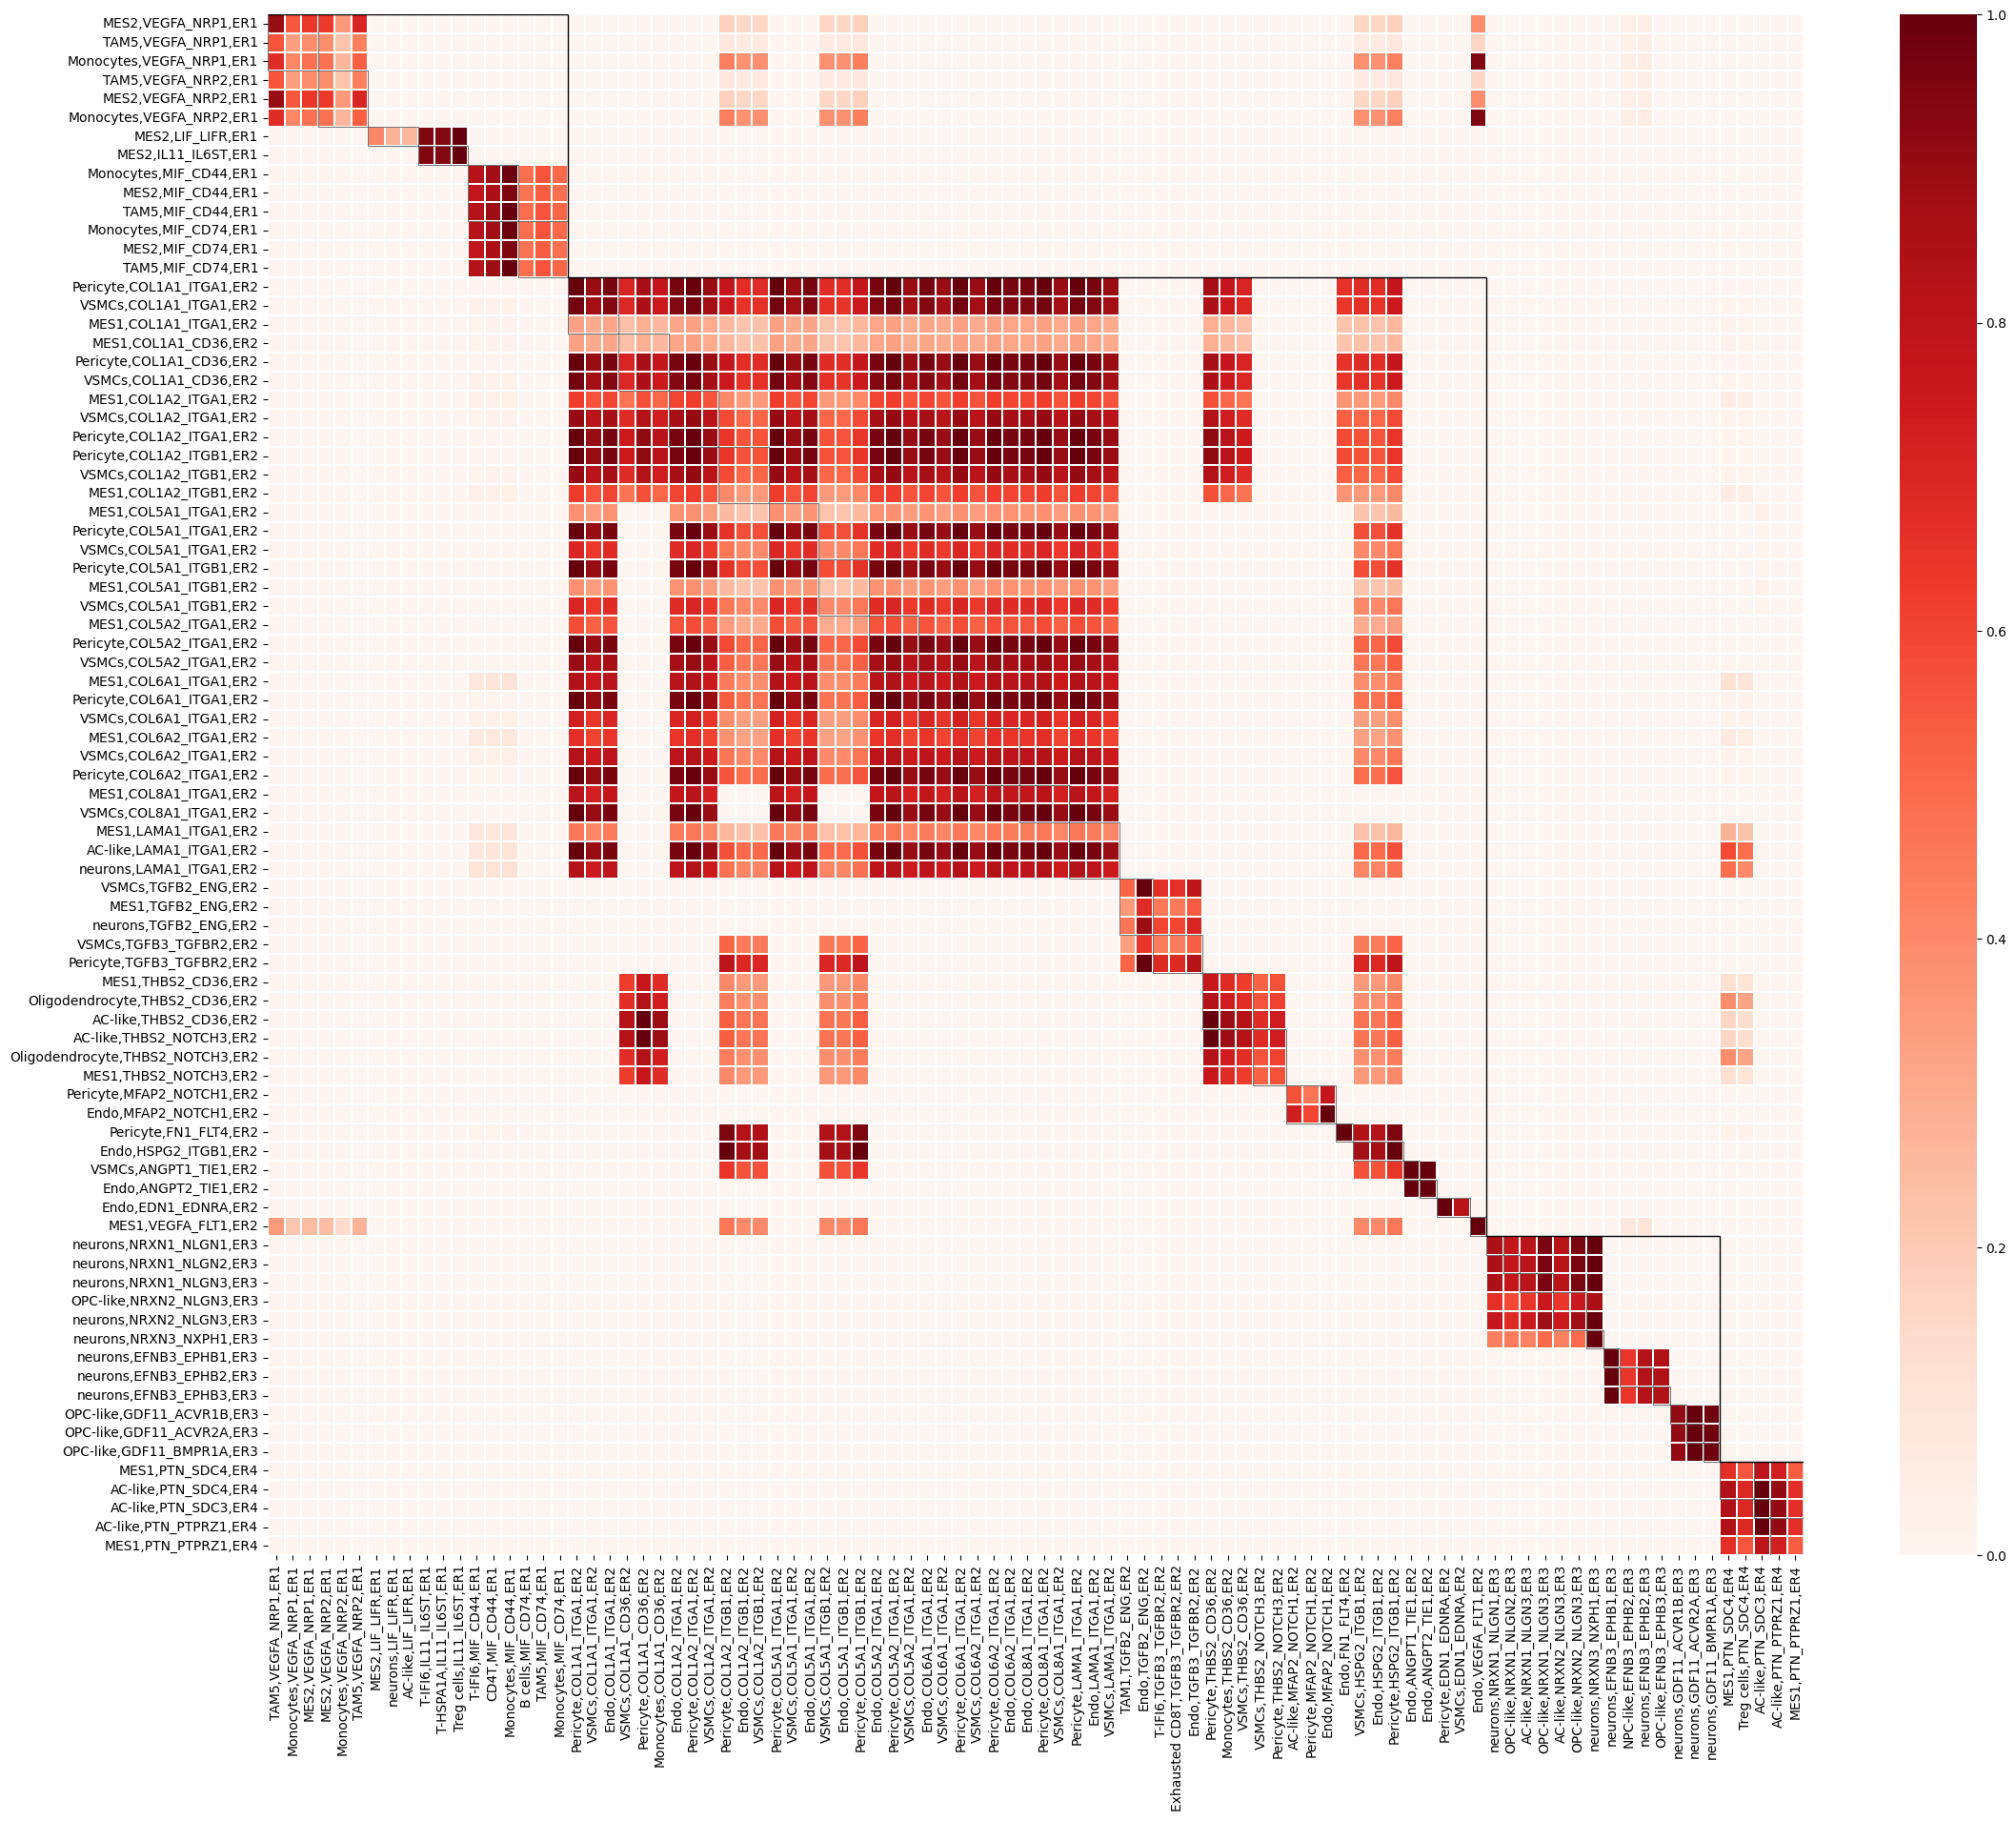

In [174]:
plt.figure(figsize=(26,21))
sns.heatmap(All_merge_triangle_scale_v3,cmap='Reds',vmax=1,vmin=0,linecolor='white',linewidths=0.2)

record_row = 0
record_col = 0
for k in range(len(row_gap_list)):
    #plt.hlines(y=record_row+row_gap_list[k],xmin=record_col,xmax=record_col+col_gap_list[k],colors='black',linewidths=1)
    plt.hlines(y=record_row,xmin=record_col,xmax=record_col+col_gap_list[k],colors='black',linewidths=1)
    plt.vlines(x=record_col+col_gap_list[k],ymin=record_row,ymax=record_row+row_gap_list[k],colors='black',linewidths=1)
    #plt.vlines(x=record_col,ymin=record_row,ymax=record_row+row_gap_list[k],colors='black',linewidths=1)
    record_row = record_row + row_gap_list[k]
    record_col = record_col + col_gap_list[k]

record_row = 0
record_col = 0

for k in range(len(row_count_record)):
    plt.hlines(y=record_row+row_count_record[k],xmin=record_col,xmax=record_col+col_count_record[k],colors='black',linewidths=0.4)
    plt.hlines(y=record_row,xmin=record_col,xmax=record_col+col_count_record[k],colors='black',linewidths=0.4)
    plt.vlines(x=record_col+col_count_record[k],ymin=record_row,ymax=record_row+row_count_record[k],colors='black',linewidths=0.4)
    plt.vlines(x=record_col,ymin=record_row,ymax=record_row+row_count_record[k],colors='black',linewidths=0.4)
    record_row = record_row + row_count_record[k]
    record_col = record_col + col_count_record[k]

plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_2/Fig_2_Interaction_fig_v3.pdf')

In [166]:
clust_colors = {'TAM1':'#17728C','TAM2':'#C1EDF6','TAM3':'#C5E5BD','TAM4':'#89CFC5','TAM5':'#AA5FAC','Monocytes':'#748EBF','DC cells':'#00C8FB',\
                'Oligodendrocyte':'#AE958C',\
                'B cells':'#ECD157', 'Plasma cells':'#DABB57',\
                'Treg cells':'#fc912a','T-IFI6':'#FF6666',\
                'Cytotoxic CD8T':'#FD9DC6','Exhausted CD8T':'#eedce4',\
                'CD4T':'#FFB3A1','T-HSPA1A':'#FFD9CE',\
                'NK cells':'#FF3D73',\
                'MES1':'#4169E1','MES2':'#D7008C','AC-like':'#FED100','OPC-like':'#00A555','NPC-like':'#16CB55',\
                'neurons':'#4C8266',\
                'Pericyte':'#C83726','VSMCs':'#972826','Endo':'#F51F1A'}

rowcolor = [ clust_colors[item.split(',')[0]] for item in All_merge_triangle_scale.index]
colcolor = [ clust_colors[item.split(',')[0]] for item in All_merge_triangle_scale.columns]

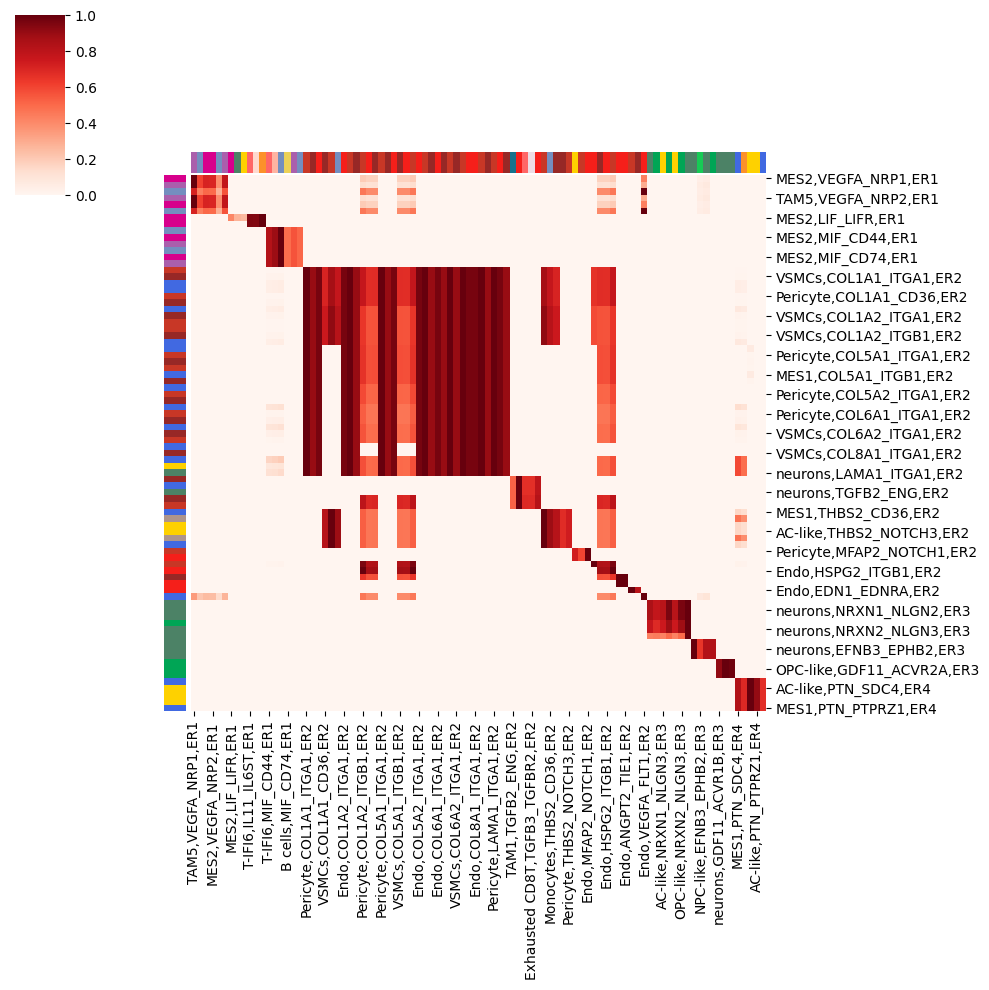

In [167]:

sns.clustermap(All_merge_triangle_scale,cmap='Reds',vmax=1,vmin=0,linecolor='white',linewidths=0.001,row_colors=rowcolor,col_colors=colcolor,row_cluster=False,col_cluster=False,rasterized=True)
plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_2/Fig_2_Interaction_fig_colorbar.pdf')

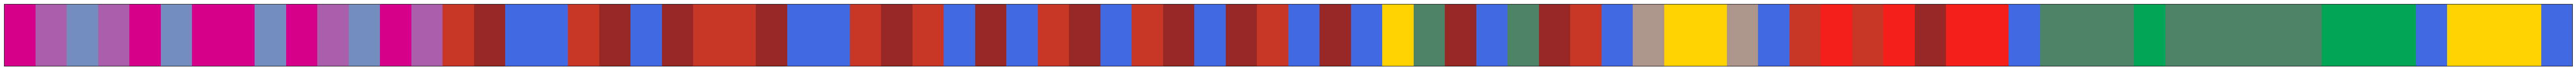

In [168]:
# List of colors (you can add more colors to this list)
colors = rowcolor

# Number of colors
n = len(colors)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(n, 2))

# Create a colormap from the list of colors
cmap = plt.cm.colors.ListedColormap(colors)

# Create a color bar
cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=ax, orientation='horizontal')

# Hide the ticks on the color bar
cb.set_ticks([])

plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_2/LR_inter_row_colorbar.pdf')

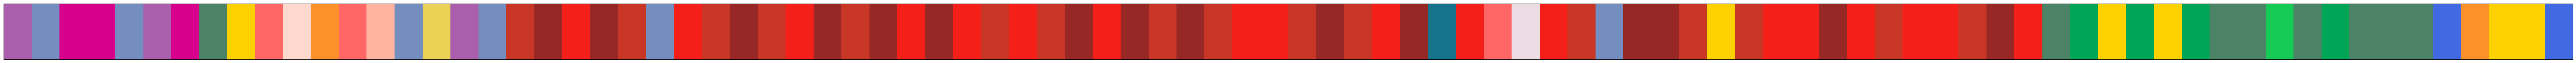

In [169]:
# List of colors (you can add more colors to this list)
colors = colcolor

# Number of colors
n = len(colors)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(n, 2))

# Create a colormap from the list of colors
cmap = plt.cm.colors.ListedColormap(colors)

# Create a color bar
cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=ax, orientation='horizontal')

# Hide the ticks on the color bar
cb.set_ticks([])

plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_2/LR_inter_col_colorbar.pdf')

In [171]:
'ERs color dict'
ER_colors = {'ER1':'#B42373','ER2':'#B43826','ER3':'#5FBE9B','ER4':'#F4A949'}
rowcolor = [ ER_colors[item.split(',')[-1]] for item in All_merge_triangle_scale.index]
colcolor = [ ER_colors[item.split(',')[-1]] for item in All_merge_triangle_scale.columns]

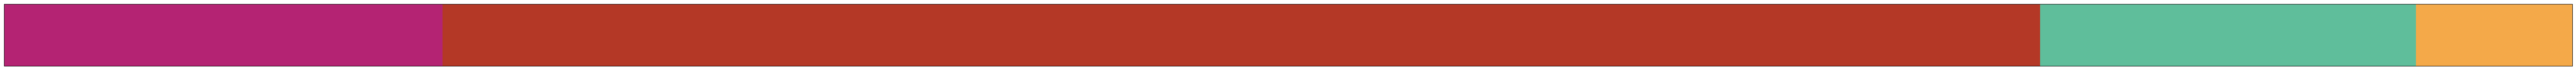

In [172]:
# List of colors (you can add more colors to this list)
colors = rowcolor

# Number of colors
n = len(colors)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(n, 2))

# Create a colormap from the list of colors
cmap = plt.cm.colors.ListedColormap(colors)

# Create a color bar
cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=ax, orientation='horizontal')

# Hide the ticks on the color bar
cb.set_ticks([])

plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_2/LR_inter_row_colorbar_ER.pdf')

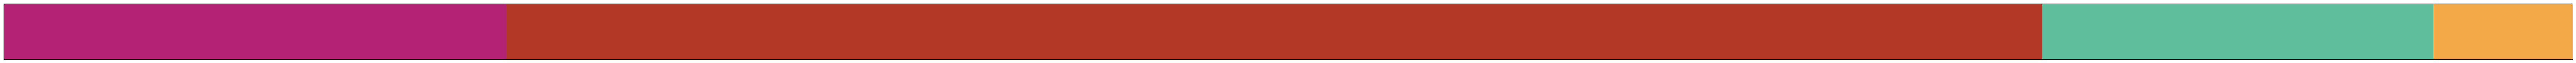

In [173]:
# List of colors (you can add more colors to this list)
colors = colcolor

# Number of colors
n = len(colors)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(n, 2))

# Create a colormap from the list of colors
cmap = plt.cm.colors.ListedColormap(colors)

# Create a color bar
cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=ax, orientation='horizontal')

# Hide the ticks on the color bar
cb.set_ticks([])

plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_2/LR_inter_col_colorbar_ER.pdf')